# Walmart Sales Prediction

## Introduction
Accurate sales forecasting is critical for effective inventory management, staffing, and overall business growth, especially in large retail chains like Walmart. By leveraging historical sales data, stores can better anticipate future demand, optimize stock levels, and plan promotions more effectively. Predicting weekly sales at the department level for each Walmart store is essential for maintaining operational efficiency and enhancing customer satisfaction.

## Objective
The primary objective of this analysis is to predict weekly sales for Walmart stores at the department level. This will be done by using time-series data and various machine learning models. The analysis will focus on understanding the factors that influence sales, such as holidays, markdown events, and macroeconomic indicators like unemployment rates and fuel prices.

## Dataset
Three datasets are used in this analysis:

1. **Sales Data**: Contains weekly sales information for each store and department, along with indicators of whether a given week was a holiday.
2. **Features Data**: Contains additional information such as temperature, fuel prices, markdowns, and macroeconomic indicators for each store and week.
3. **Stores Data**: Contains information about each store, including store size and type.

### Data Dictionary

#### Sales Data
| Column         | Description                                                |
|----------------|------------------------------------------------------------|
| `Store`        | The ID of the store                                         |
| `Dept`         | The ID of the department                                    |
| `Date`         | The week of sales                                           |
| `Weekly_Sales` | Sales for the given department in the given store           |
| `IsHoliday`    | Boolean flag indicating if the week is a special holiday    |

#### Features Data
| Column         | Description                                                |
|----------------|------------------------------------------------------------|
| `Store`        | The ID of the store                                         |
| `Date`         | The week corresponding to the feature values                |
| `Temperature`  | Average temperature during the week                         |
| `Fuel_Price`   | Fuel price in the region during the week                    |
| `MarkDown1-5`  | Markdown data for the given week, representing promotions   |
| `CPI`          | Consumer Price Index for the region                        |
| `Unemployment` | Unemployment rate in the region                             |
| `IsHoliday`    | Boolean flag indicating if the week is a special holiday    |

#### Stores Data
| Column         | Description                                                |
|----------------|------------------------------------------------------------|
| `Store`        | The ID of the store                                         |
| `Type`         | The type of the store (A, B, or C)                          |
| `Size`         | The square footage of the store                             |

## Summary
The analysis will use these datasets to explore the relationships between different features and their impact on weekly sales. This exploration will help build predictive models that can forecast sales, accounting for various factors like holidays, markdown events, and macroeconomic conditions.


In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pip installations
!pip install pmdarima

In [ ]:
# Import necessary libraries and packages
import math
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the datasets
sales_data= pd.read_csv('/content/drive/My Drive/sales_data.csv')
features_data= pd.read_csv('/content/drive/My Drive/features.csv')
stores_data= pd.read_csv('/content/drive/My Drive/stores.csv')

In [ ]:
# View the sales dataset
sales_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
# View the features dataset
features_data.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
# View the stores dataset
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
# Define the separator dash line
dash_line= '-' * 75

In [ ]:
# Explore 'sales_data'
print('Sales Data Shape:', sales_data.shape)
print(dash_line)
print('Sales Data Columns:', sales_data.columns)
print(dash_line)
print('Sales Data Info:', sales_data.info())
print(dash_line)
print('Sales Data Missing Values:\n', sales_data.isna().sum())
print(dash_line)
print('Sales Data Unique Values:\n', sales_data.nunique())
print(dash_line)
print('Sales Data Summary Statistics:\n', sales_data.describe())

Sales Data Shape: (421570, 5)
---------------------------------------------------------------------------
Sales Data Columns: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
Sales Data Info: None
---------------------------------------------------------------------------
Sales Data Missing Values:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
-

In [ ]:
# Explore 'features_data'
print('Features Data Shape:\n', features_data.shape)
print(dash_line)
print('Features Data Columns:\n', features_data.columns)
print(dash_line)
print('Features Data Info:\n', features_data.info())
print(dash_line)
print('Features Data Missing Values:\n', features_data.isna().sum())
print(dash_line)
print('Features Data Unique Values:\n', features_data.nunique())
print(dash_line)
print('Features Data Summary Statistics:\n', features_data.describe())

Features Data Shape:
 (8190, 12)
---------------------------------------------------------------------------
Features Data Columns:
 Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7

In [ ]:
# Explore 'stores_data'
print('Stores Data Shape:\n', stores_data.shape)
print(dash_line)
print('Stores Data Columns:\n', stores_data.columns)
print(dash_line)
print('Stores Data Info:\n', stores_data.info())
print(dash_line)
print('Stores Data Missing Values:\n', stores_data.isna().sum())
print(dash_line)
print('Stores Data Unique Values:\n', stores_data.nunique())
print(dash_line)
print('Stores Data Summary Statistics:\n', stores_data.describe())

Stores Data Shape:
 (45, 3)
---------------------------------------------------------------------------
Stores Data Columns:
 Index(['Store', 'Type', 'Size'], dtype='object')
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
Stores Data Info:
 None
---------------------------------------------------------------------------
Stores Data Missing Values:
 Store    0
Type     0
Size     0
dtype: int64
---------------------------------------------------------------------------
Stores Data Unique Values:
 Store    45
Type      3
Size     40
dtype: int64
---------------------------------------------------------------------------
Stores Data S

# Walmart Sales Prediction - Initial Data Exploration

## Overview of Datasets
The analysis focuses on three datasets: **Sales Data**, **Features Data**, and **Stores Data**. Below is a summary of each dataset, including its shape, columns, and key insights.

### 1. Sales Data
- **Shape**: (421,570 rows, 5 columns)
- **Key Columns**:
  - `Store`: 45 unique stores
  - `Dept`: 81 unique departments
  - `Date`: Sales data spans 143 unique dates
  - `Weekly_Sales`: Weekly sales figures for each department-store combination
  - `IsHoliday`: Boolean indicator of whether a given week is a holiday
- **Key Insights**:
  - No missing values across the dataset.
  - Sales values range from below 0 (possibly indicating returns or anomalies) to a maximum of \$693,099.
  - Departments and stores are consistently represented across all weeks.

### 2. Features Data
- **Shape**: (8,190 rows, 12 columns)
- **Key Columns**:
  - `Store`: Corresponds to the store from Sales Data
  - `Date`: Date column to align with the sales data
  - `Temperature`: Weather data for the respective weeks
  - `Fuel_Price`, `MarkDown1-5`: Economic indicators and markdowns, partially missing
  - `CPI`, `Unemployment`: Macroeconomic indicators with some missing values
  - `IsHoliday`: A boolean indicator for holiday weeks
- **Key Insights**:
  - There are missing values in markdowns and macroeconomic indicators (`CPI` and `Unemployment`).
  - Temperature ranges from -7.29 to 101.95 degrees, and fuel prices fluctuate between 2.47 and 4.47.
  - Markdowns have significant missing values, especially `MarkDown2` and `MarkDown4`.

### 3. Stores Data
- **Shape**: (45 rows, 3 columns)
- **Key Columns**:
  - `Store`: Identifies each store (corresponds to Sales and Features Data)
  - `Type`: Three unique store types (A, B, and C)
  - `Size`: The size of each store
- **Key Insights**:
  - No missing values.
  - Store sizes range from 34,875 to 219,622 square feet, with an average size of approximately 130,287 square feet.

## Summary
The data contains complete sales records with no missing values. However, features like markdowns and macroeconomic indicators have some missing data that will need to be addressed. Further analysis will focus on time series trends, store-level sales, and the impact of markdowns and holidays on weekly sales.


In [ ]:
# Convert 'Store' and 'Dept' columns to string type for consistency
sales_data['Store']= sales_data['Store'].astype(str)
sales_data['Dept']= sales_data['Dept'].astype(str)

# Convert 'IsHoliday' to numeric (0 or 1)
sales_data['IsHoliday']= sales_data['IsHoliday'] * 1

In [ ]:
# Check if there any records where 'Weekly_Sales' are less than or erqual to 0
sales_data_check= sales_data.loc[sales_data['Weekly_Sales'] <= 0]

# Output the shape and percentage of records with 'Weekly_Sales' <= 0
sales_data_check.shape, sales_data_check.shape[0] / sales_data.shape[0]

((1358, 5), 0.003221291837654482)

In [ ]:
# Drop these records since it's such a small percentage
sales_data= sales_data.loc[sales_data['Weekly_Sales'] > 0]

# Check the shape of the dataset after dropping the records
sales_data.shape

(420212, 5)

In [ ]:
# Convert 'Store' column in features_data and stores_data for consistency
features_data['Store']= features_data['Store'].astype(str)
stores_data['Store']= stores_data['Store'].astype(str)

# Drop 'IsHoliday' from the features_data
features_data= features_data.drop(['IsHoliday'], axis= 1)

In [ ]:
# Fill missing values in the 'Unemployment' and 'CPI' columns with the mean
features_data['Unemployment'].fillna(features_data['Unemployment'].mean(), inplace= True)
features_data['CPI'].fillna(features_data['CPI'].mean(), inplace= True)

# Fill missing values in Markdown columns with 0
features_data.fillna(0, inplace= True)

In [ ]:
# Calculate the average store size based on the store type
stores_data.groupby('Type').agg({'Size': 'mean'})

,Size
Type,
A,177247.727273
B,101190.705882
C,40541.666667


### Average Store Size by Store Type

The table above shows the **average store size** for each store type (`A`, `B`, and `C`):

- **Type A**: Average size is approximately **177,248 square feet**.
- **Type B**: Average size is around **101,191 square feet**.
- **Type C**: Average size is about **40,542 square feet**.

This indicates that:
- **Type A** stores are the largest.
- **Type B** stores are mid-sized.
- **Type C** stores are significantly smaller.

Understanding store size can be crucial for analysis as it may influence sales performance, customer traffic, and inventory management across the different store types.


In [ ]:
# Check if the number of unique (Store, Date) combinations match in features_data
features_data.groupby(['Store', 'Date']).size().shape[0] - features_data.shape[0]

0

In [ ]:
# Check if the number of unique (Store, Dept, Date) combinations match in sales_data
sales_data.groupby(['Store', 'Dept', 'Date']).size().shape[0] - sales_data.shape[0]

0

In [ ]:
# Merging sales_data with features_data on 'Store' and 'Date'
sales_features_data= pd.merge(sales_data, features_data, on= ['Store', 'Date'], how= 'inner')

# Check the shape after the merge
print('Sales Features Data Shape: ', sales_features_data.shape)

Sales Features Data Shape:  (420212, 14)


In [ ]:
# Merge the resulting data with the stores_data on 'Store'
df= pd.merge(sales_features_data, stores_data, on= 'Store', how= 'inner')

# Check the shape of the final combined dataset
print('Combined Data Shape: ', df.shape)

Combined Data Shape:  (420212, 16)


### Splitting the Data

The data is split into training and testing sets based on time, ensuring that the training set consists of the earliest 70% of the data and the test set consists of the remaining 30%. This time-based split is crucial in time series forecasting to prevent data leakage from future observations into the training data.

1. **Date Conversion**: The `Date` column is converted into a proper datetime format for accurate calculations and splitting.
   
2. **Unique Dates**: The number of unique weeks in the dataset is calculated to determine the total time range of the data.
   
3. **Splitting Logic**: The dataset is sorted by date, and the date that corresponds to the 70% mark is identified. This date is used as the split point to divide the dataset into training and testing sets.
   
4. **Final Split**:
   - The training set contains approximately 70% of the data (earliest dates).
   - The testing set contains the remaining 30% (later dates).

This ensures that future data is not used in training, which is essential for making accurate forecasts on unseen data.


In [ ]:
# Conver the 'Date' to datetime format
df['Date']= pd.to_datetime(df['Date'], format= '%Y-%m-%d')

# Check the number of unique weeks (dates) in the data
df['Date'].nunique()

143

In [ ]:
# Calculate the number of weeks between the earliest and latest dates
(df['Date'].max() - df['Date'].min()) / 7

Timedelta('142 days 00:00:00')

In [ ]:
# Get the date that corresponds to 70% of the data
unique_dates= pd.DataFrame(df['Date'].unique(), columns= ['date'])
unique_dates.sort_values('date', inplace= True)
splitter= round(unique_dates.shape[0] * 0.7, 0)

In [ ]:
# Determine the split date (70% mark)
split_date= unique_dates.iloc[int(splitter) - 1]['date']
split_date

Timestamp('2011-12-30 00:00:00')

In [ ]:
# Split the dataset into train and test sets based on the split date
df_train= df.loc[df['Date'] <= split_date]
df_test= df.loc[df['Date'] > split_date]

# Check the proportion of the data in the train set
df_train.shape[0] / df.shape[0]

0.6977525629920136

### Univariate Analysis

Univariate analysis is performed to explore the distribution of both categorical and numerical variables in the dataset. This step helps in understanding the spread, central tendencies, and potential outliers in the data.

1. **Categorical Variables**:
   - Histograms are used to visualize the distribution of each categorical variable (such as `Store`, `Dept`).
   - The number of unique categories for each variable is used to determine the appropriate number of bins in the histograms.
   - This helps in identifying how different stores and departments are distributed across the dataset.

2. **Numerical Variables**:
   - Boxplots are utilized to examine the distribution of numerical variables, both for markdown-related columns (e.g., `MarkDown1-5`) and non-markdown-related columns (e.g., `Weekly_Sales`, `Fuel_Price`).
   - Boxplots allow for easy identification of the spread, quartiles, and outliers in the data.
   - Markdown variables are of particular interest due to their potential influence on sales performance.

The analysis of categorical and numerical variables provides key insights into the structure of the data and helps inform future modeling decisions.


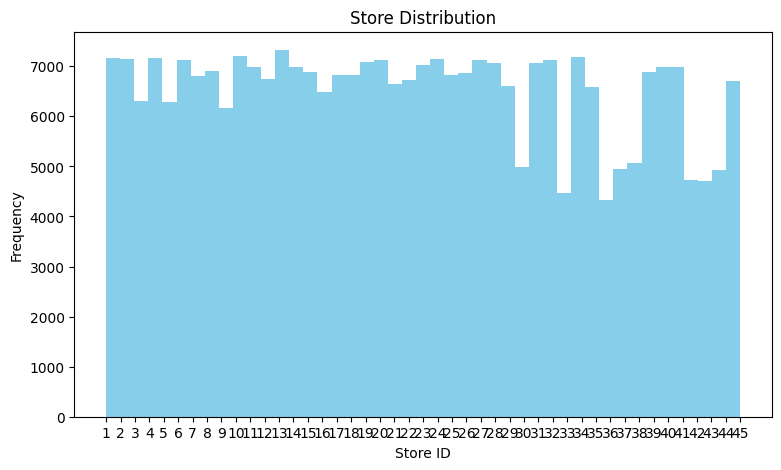

In [ ]:
# Set figure size for 'Store' histogram
plt.figure(figsize= (9,5))
plt.hist(list(df_train['Store']), bins= df_train['Store'].nunique(), color= 'skyblue')
plt.xlabel('Store ID')
plt.ylabel('Frequency')
plt.title('Store Distribution')
plt.show()

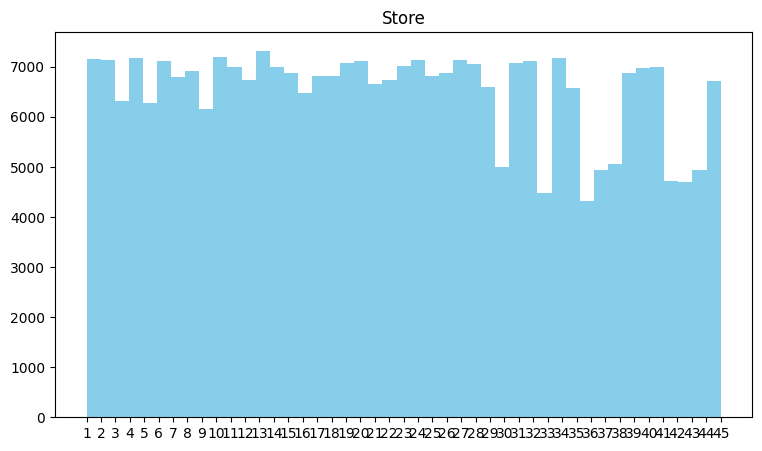

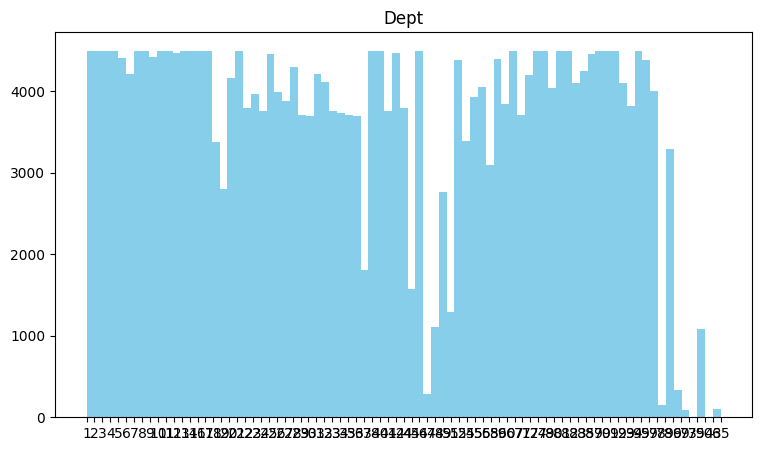

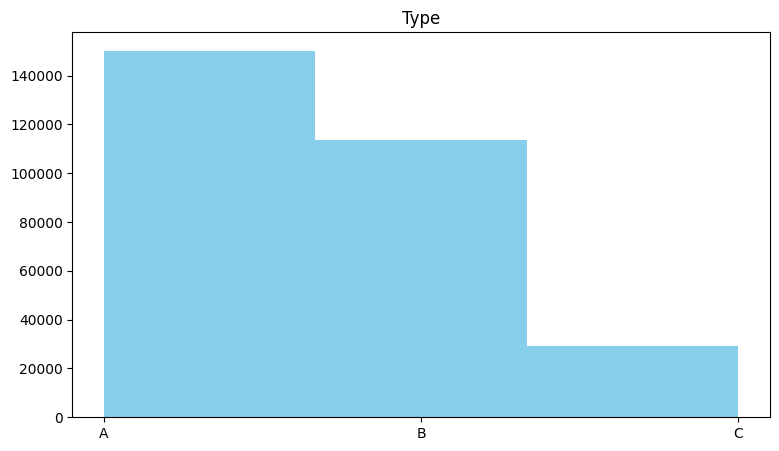

In [ ]:
# List of categorical columns
cat_cols= df_train.select_dtypes(include= ['object']).columns.tolist()

# Univariate analysis of categorical variables
for var in cat_cols:
  plt.figure(figsize= (9,5))
  plt.hist(list(df_train[var]), bins= df_train[var].nunique(), color= 'skyblue')
  plt.title(var)
  plt.show()

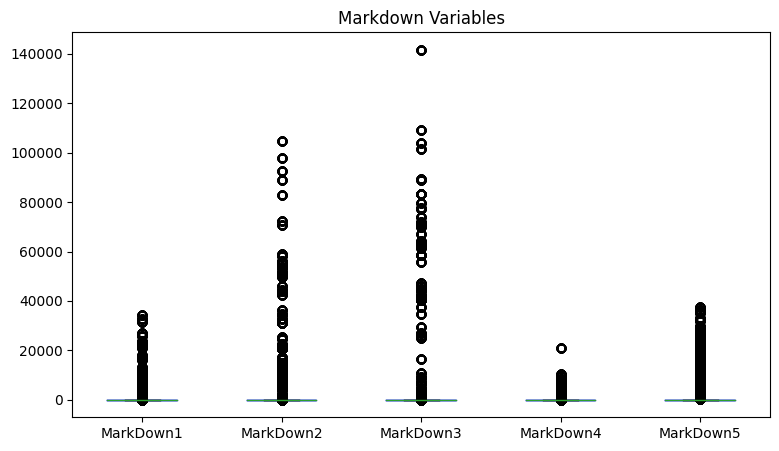

In [ ]:
# List of numerical columns
num_cols= df_train.select_dtypes(include= [np.number]).columns.tolist()

# Separating markdown and non-markdown columns
mark_cols= [x for x in num_cols if 'Mark' in x]
nonmark_cols= list(set(num_cols).difference(set(mark_cols)))

# Boxplots for markdown-related columns
df_train.boxplot(column= mark_cols, figsize= (9,5), boxprops= dict(color= 'blue'), grid= False)
plt.title('Markdown Variables')
plt.show()

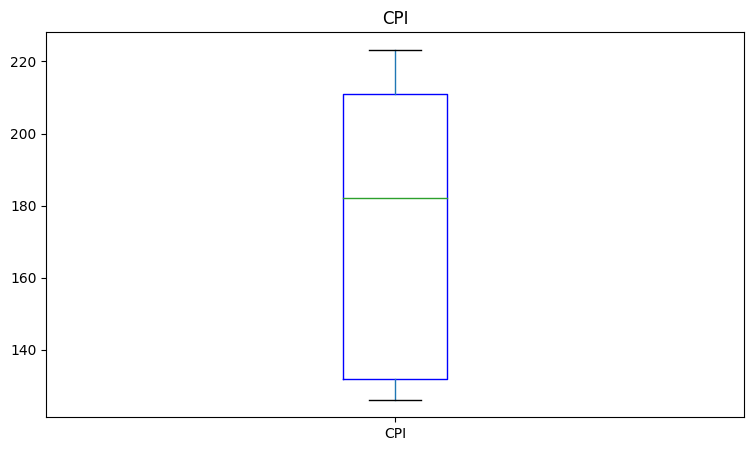

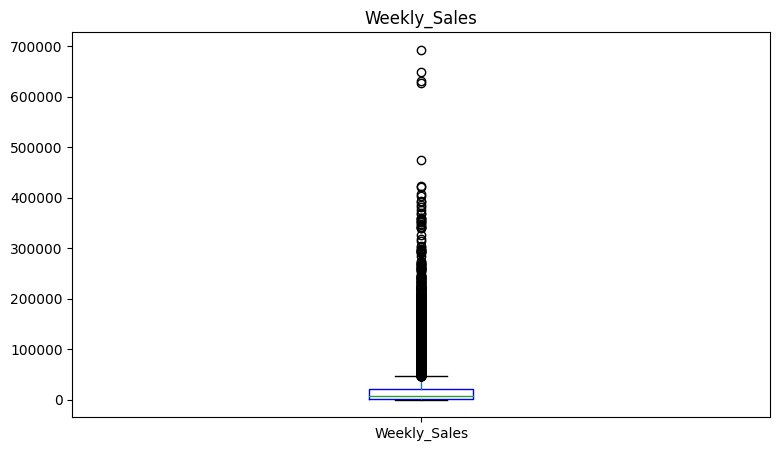

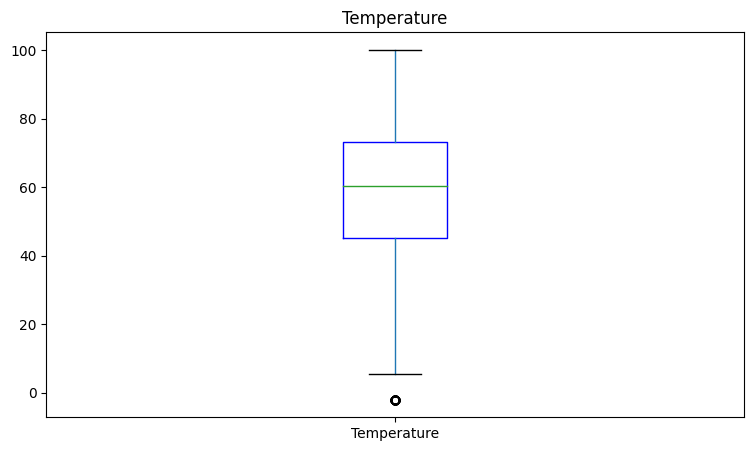

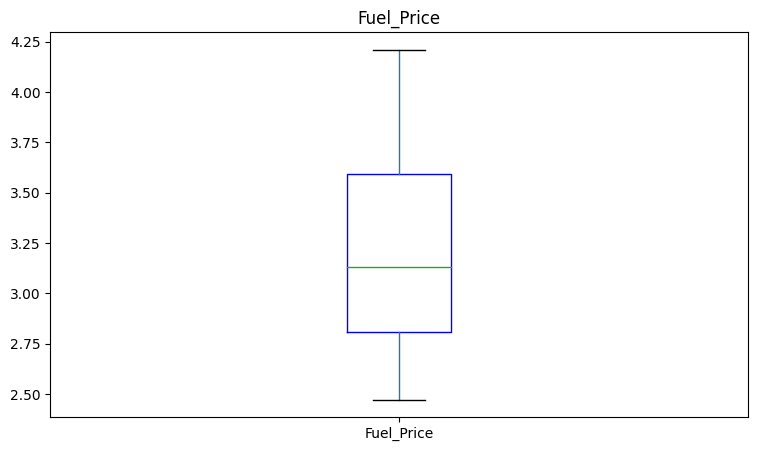

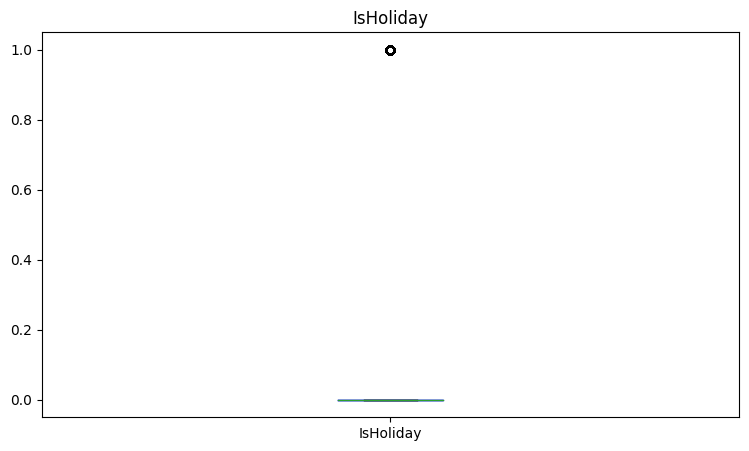

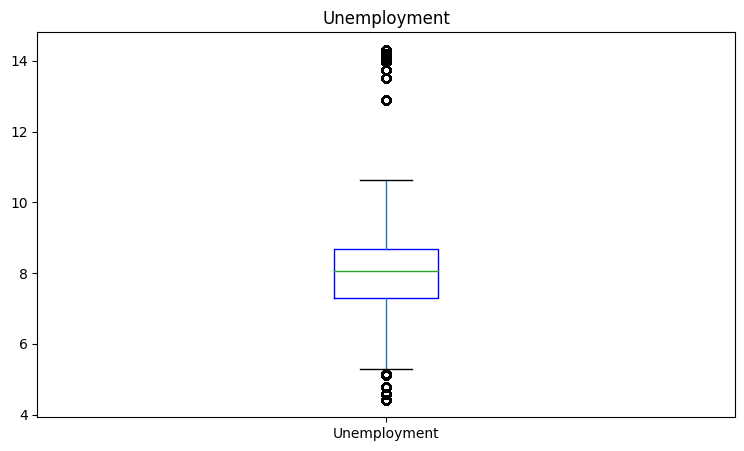

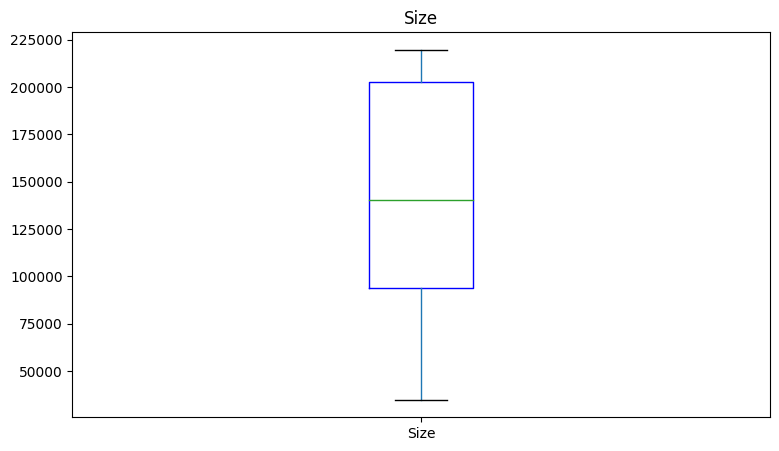

In [ ]:
# Boxplot for non-markdown columns
for var in nonmark_cols:
  df_train.boxplot(column= var, figsize= (9,5), boxprops= dict(color= 'blue'), grid= False)
  plt.title(var)
  plt.show()

### Bivariate Analysis

Bivariate analysis is conducted to explore the relationships between numerical variables. This helps identify potential correlations and dependencies that can impact model performance.

1. **Numeric Predictors**:
   - All numerical columns except the target variable (`Weekly_Sales`) are selected for analysis.
   
2. **Correlation Check**:
   - Correlation values between all pairs of numerical predictors are calculated using Pearson correlation. This helps in identifying highly correlated variables, which can lead to multicollinearity issues in predictive models.
   - The correlation matrix is unstacked and sorted by absolute correlation values to easily identify the strongest relationships.

3. **Heatmap Visualization**:
   - A heatmap is plotted to visualize the degree of correlation between numerical predictors. This allows for a quick assessment of highly correlated pairs.

4. **Pairplot**:
   - A pairplot is generated to plot each numeric predictor against the others. This helps in visualizing the relationships and patterns between different predictors, as well as identifying any linear or nonlinear trends.



In [ ]:
# Keeping the numeric predictors, while excluding the target features 'Weekly_Sales'
train_num= df_train[num_cols]
train_num= train_num.drop(['Weekly_Sales'], axis= 1)
train_num.head()

,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
0,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
1,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
2,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
3,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
4,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315


In [ ]:
# Checking for highly correlated variables
corr_values= train_num.corr().unstack().reset_index()
corr_values.shape

(121, 3)

In [ ]:
# Filtering out redundant pairs and keeping only unique pairs
corr_values2= corr_values[corr_values['level_0'] > corr_values['level_1']]
corr_values2.shape

(55, 3)

In [ ]:
# Renaming columns for better readability
corr_values2.columns= ['var1', 'var2', 'corr_value']
corr_values2['corr_abs']= corr_values2['corr_value'].abs()

# Sorting by asbolute correlation values
corr_values2.sort_values('corr_abs', ascending= False, inplace= True)
corr_values2.head()

,var1,var2,corr_value,corr_abs
69,MarkDown4,MarkDown1,0.764146,0.764146
83,MarkDown5,MarkDown4,0.673759,0.673759
80,MarkDown5,MarkDown1,0.573937,0.573937
47,MarkDown2,MarkDown1,0.364552,0.364552
107,Unemployment,CPI,-0.298205,0.298205


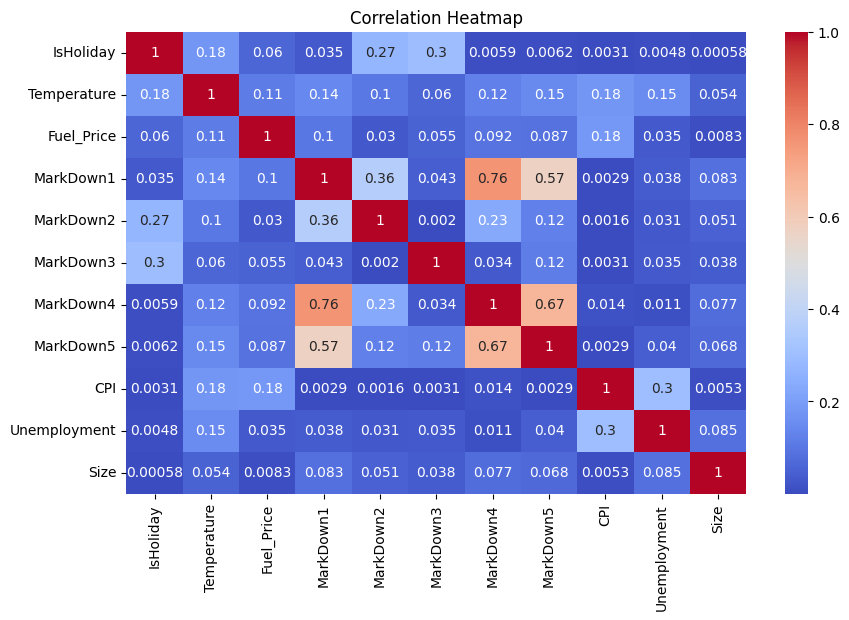

In [ ]:
# Plot heatmap to visualize correlations
plt.figure(figsize= (10,6))
vg_corr= train_num.corr().abs()
sns.heatmap(vg_corr, xticklabels= vg_corr.columns.values, yticklabels= vg_corr.columns.values, annot= True, cmap= 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

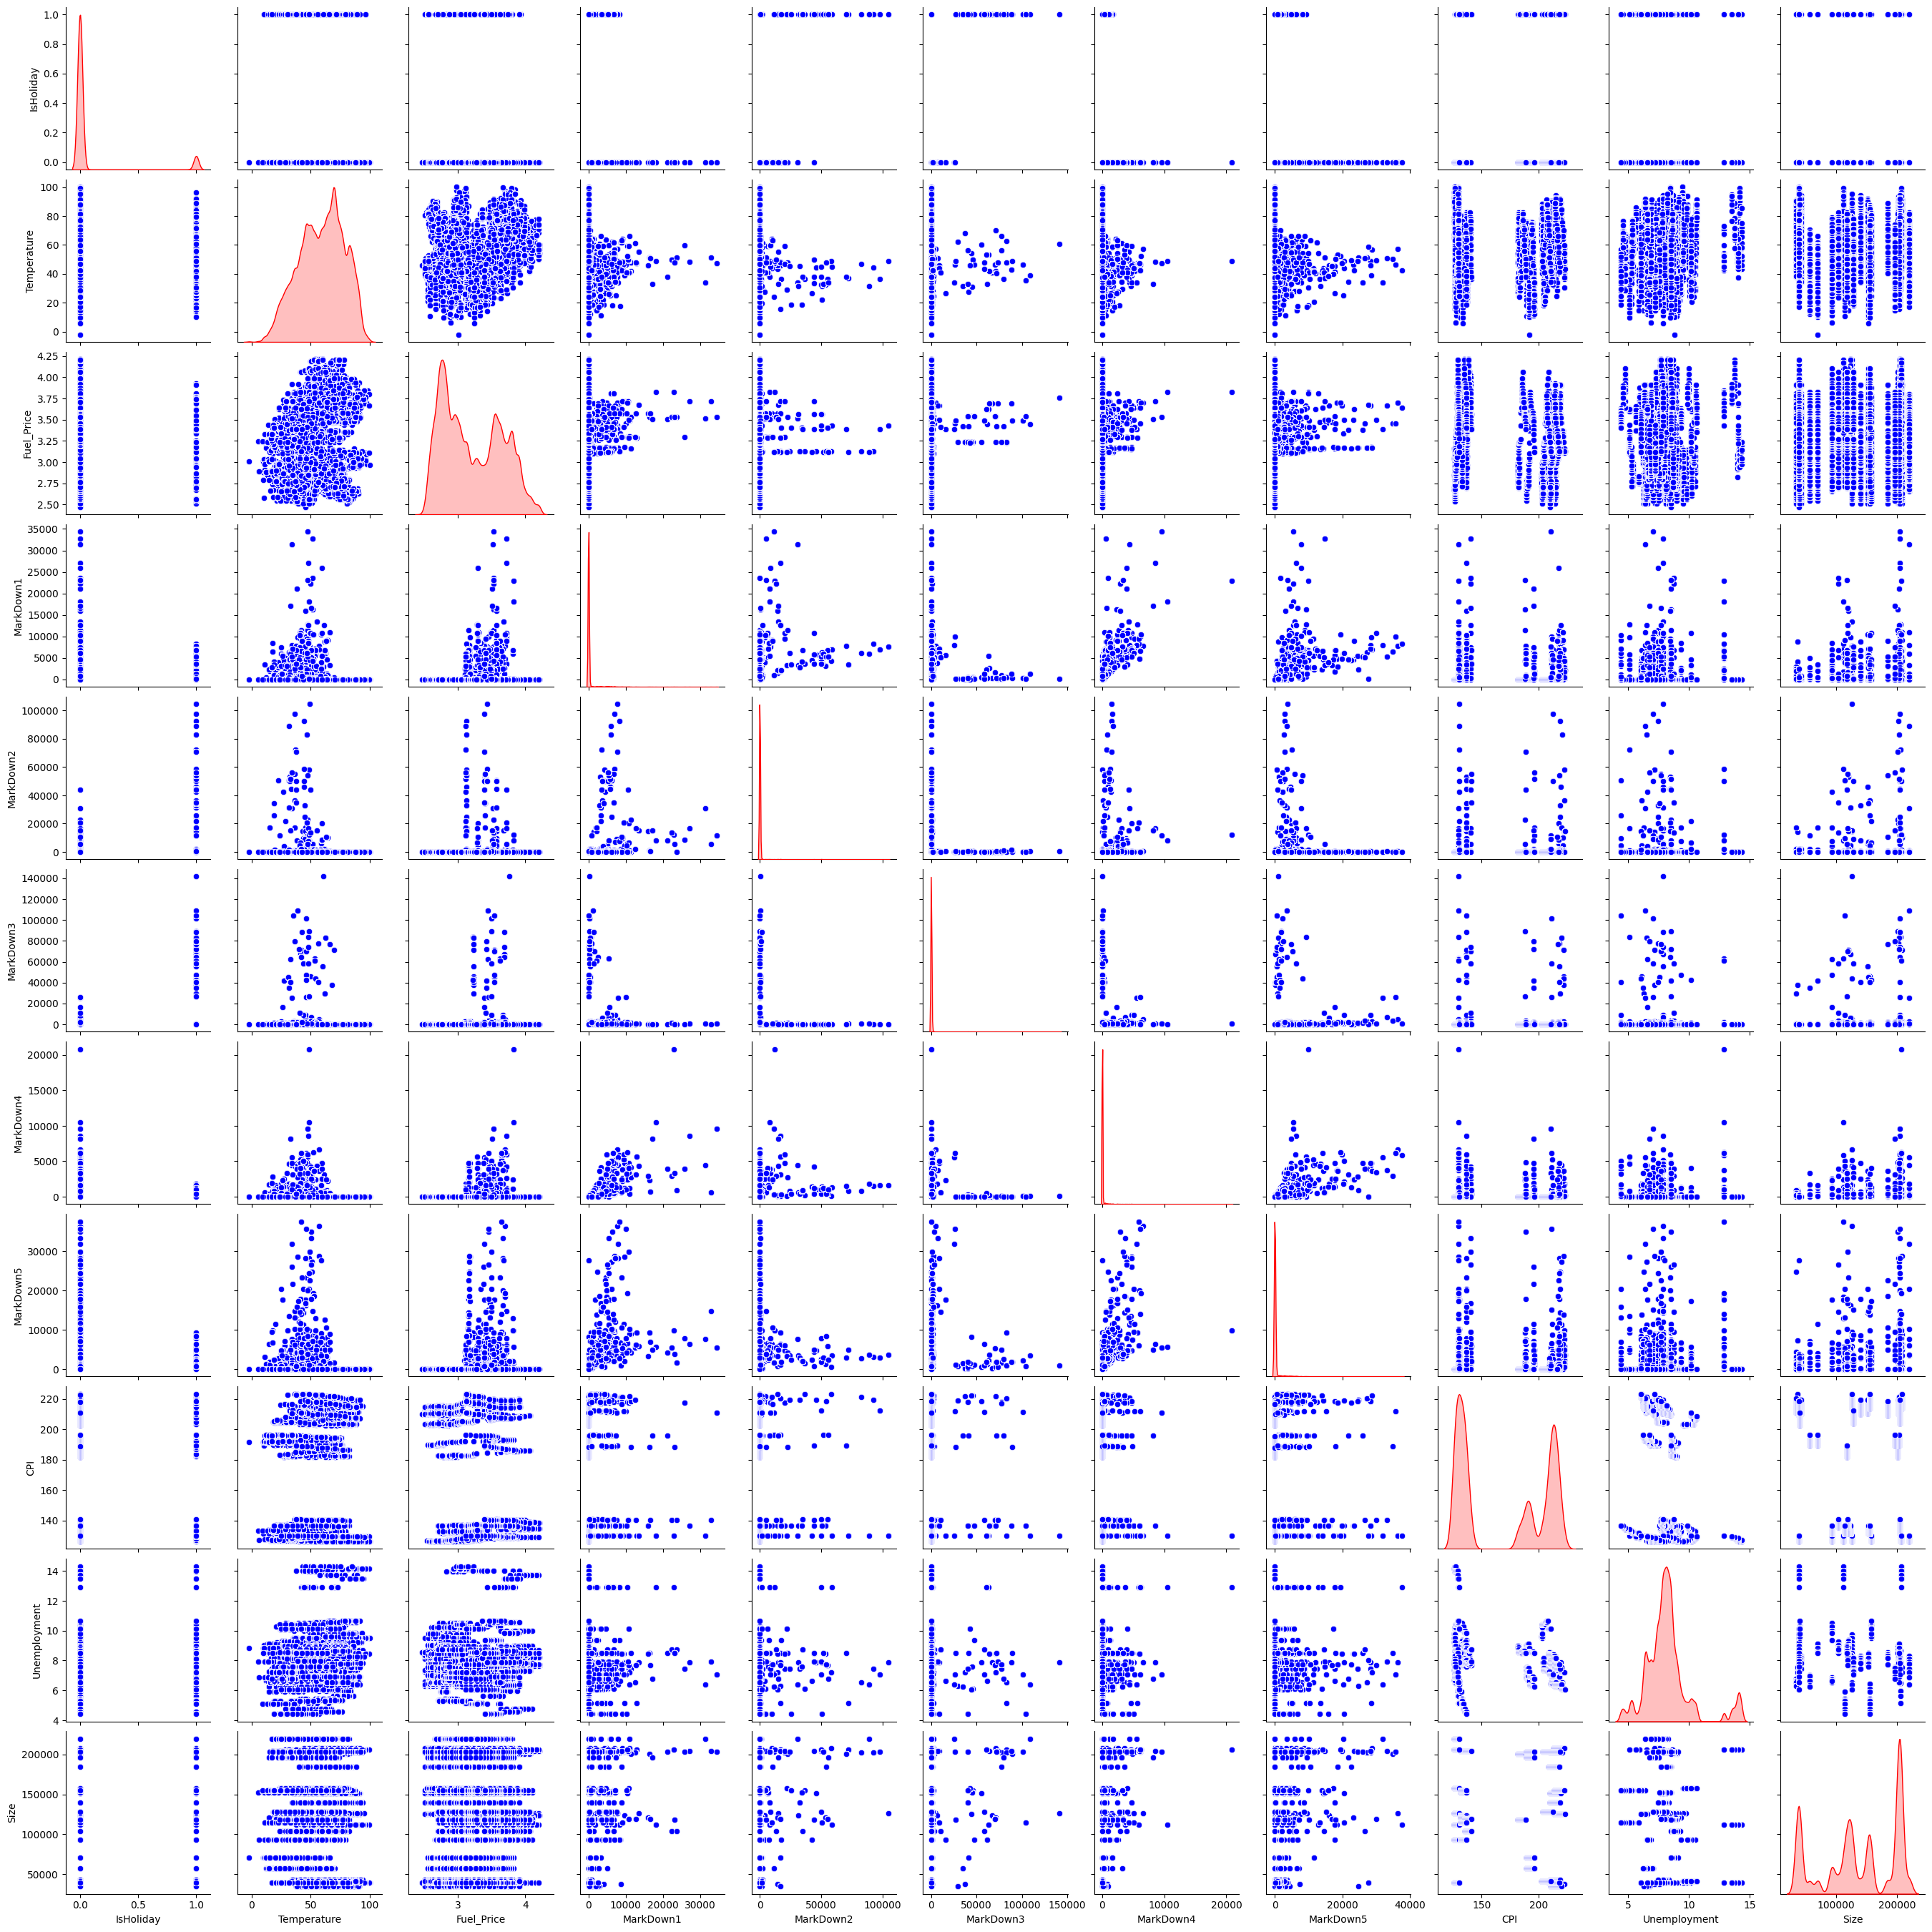

In [ ]:
# Plot numeric predictors against the others
sns.pairplot(train_num, diag_kind= 'kde', plot_kws= {'color':'blue'}, diag_kws= {'color':'red'})
plt.show()

Store
    Store  Weekly_Sales
0       1  21545.888896
11      2  27155.512780
22      3   6270.950455
33      4  28818.633190
40      5   4980.471872


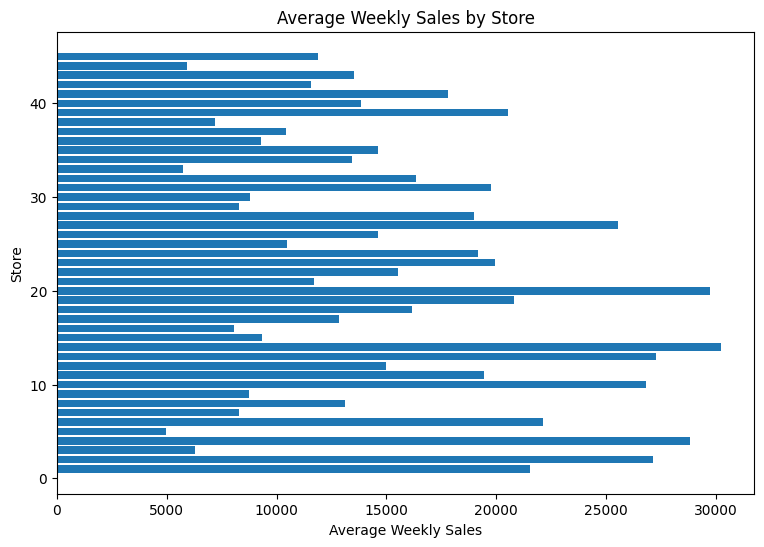

Dept
    Dept  Weekly_Sales
0      1  19598.410840
10     2  43457.375233
21     3  11579.856289
32     4  25809.642924
43     5  23154.604378


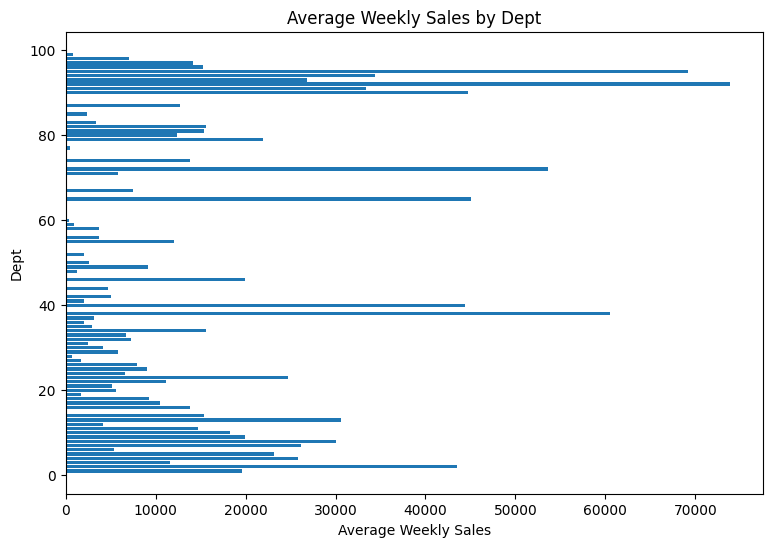

In [ ]:
# Examining the trande of average weekly sales by 'Store' and 'Dept'
for var in ['Store', 'Dept']:
  print(var)

  # Grouping by 'Store'/'Dept' and 'Date', then calculating the total 'Weekly_Sales'
  agg_temp= df_train.groupby([var, 'Date'], as_index= False).agg({'Weekly_Sales':'sum'})

  # Grouping by 'Store'/'Dept' and calculating the average 'Weekly_Sales'
  agg_temp2= df_train.groupby([var], as_index= False).agg({'Weekly_Sales':'mean'})

  # Convert the values to numeric type for sorting
  agg_temp2[var]= pd.to_numeric(agg_temp2[var])

  # Sort values by 'Store'/'Dept'
  agg_temp2.sort_values(var, inplace= True)

  # Print the first few rows to inspect the data
  print(agg_temp2.head())

  # Plot average weekly sales for each 'Store'/'Dept'
  plt.figure(figsize= (9,6))
  plt.barh(agg_temp2[var], agg_temp2['Weekly_Sales'])
  plt.xlabel('Average Weekly Sales')
  plt.ylabel(var)
  plt.title('Average Weekly Sales by ' + var)
  plt.show()

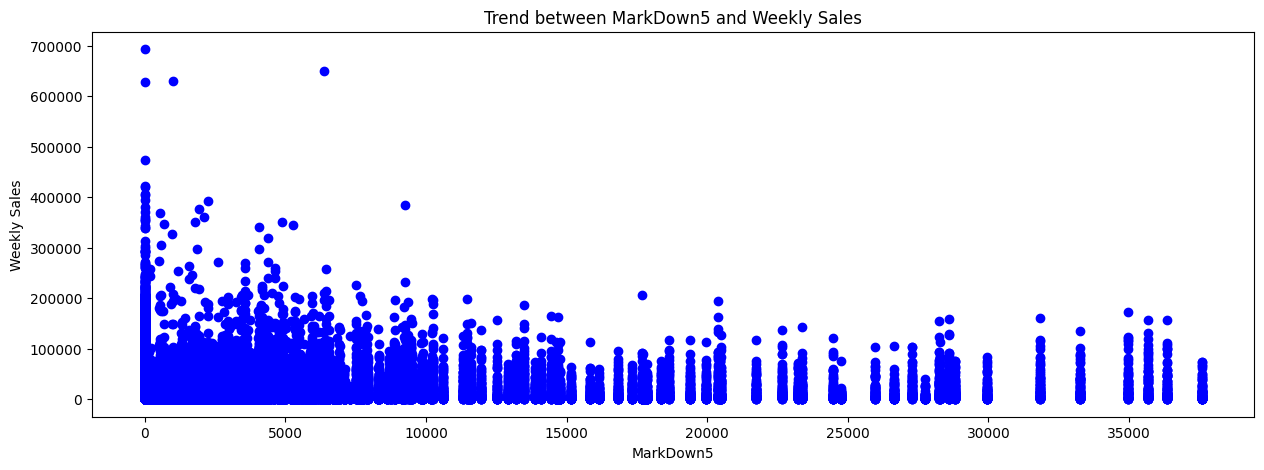

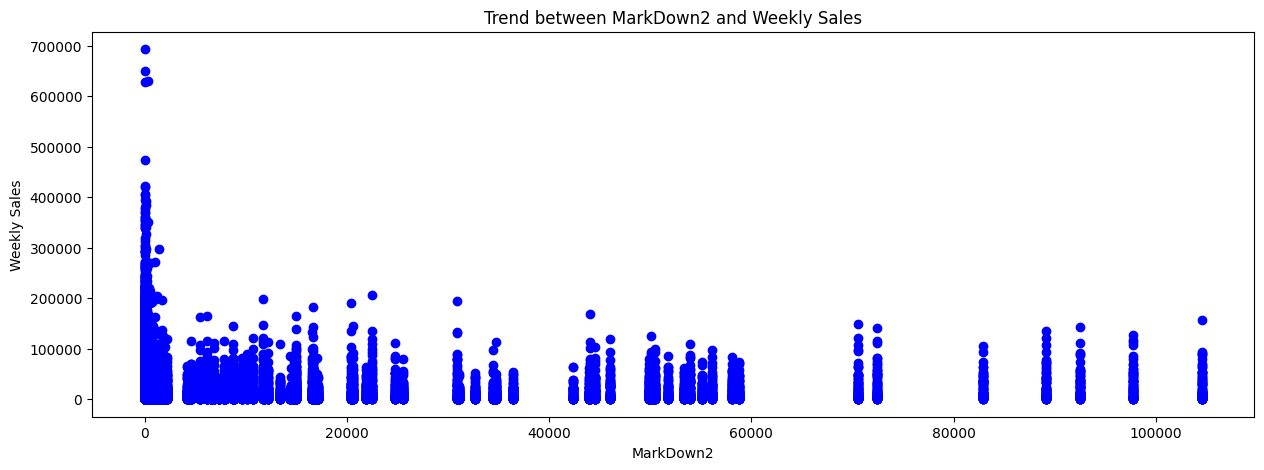

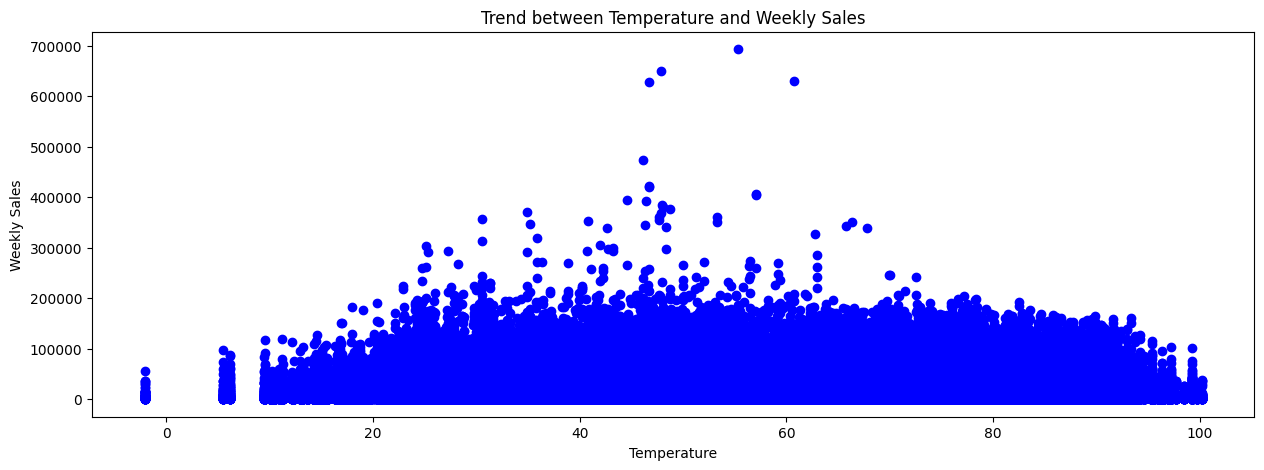

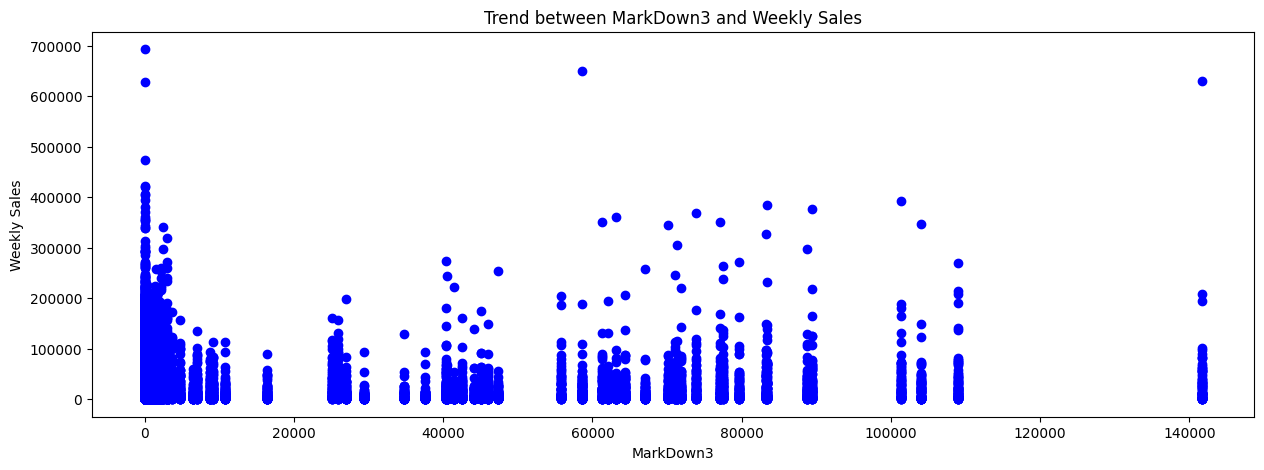

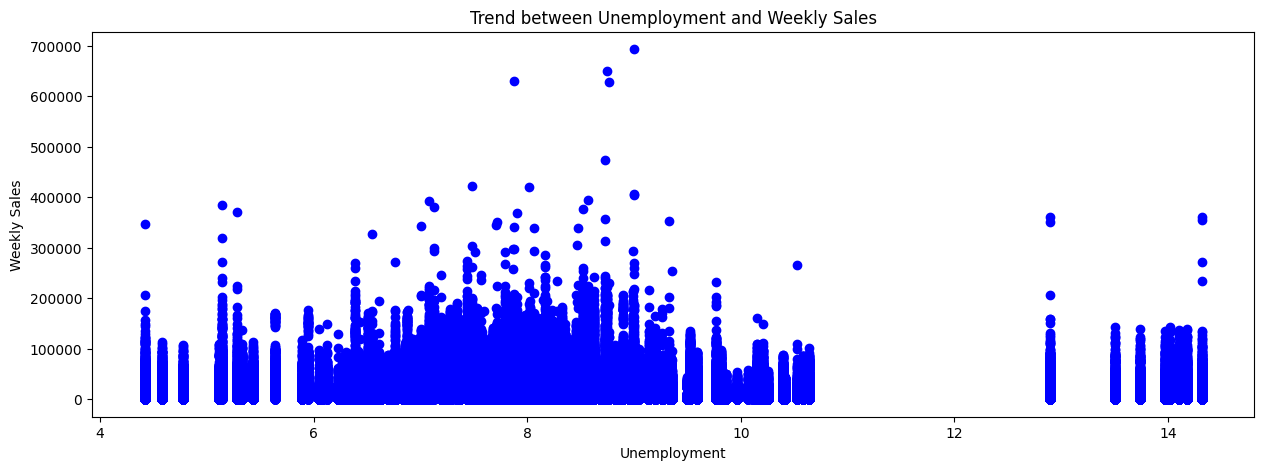

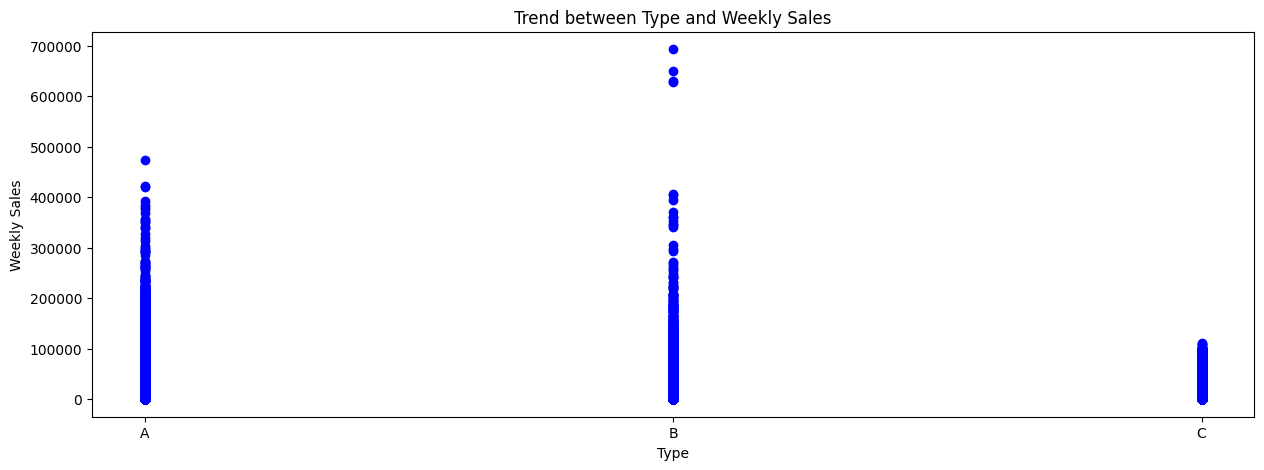

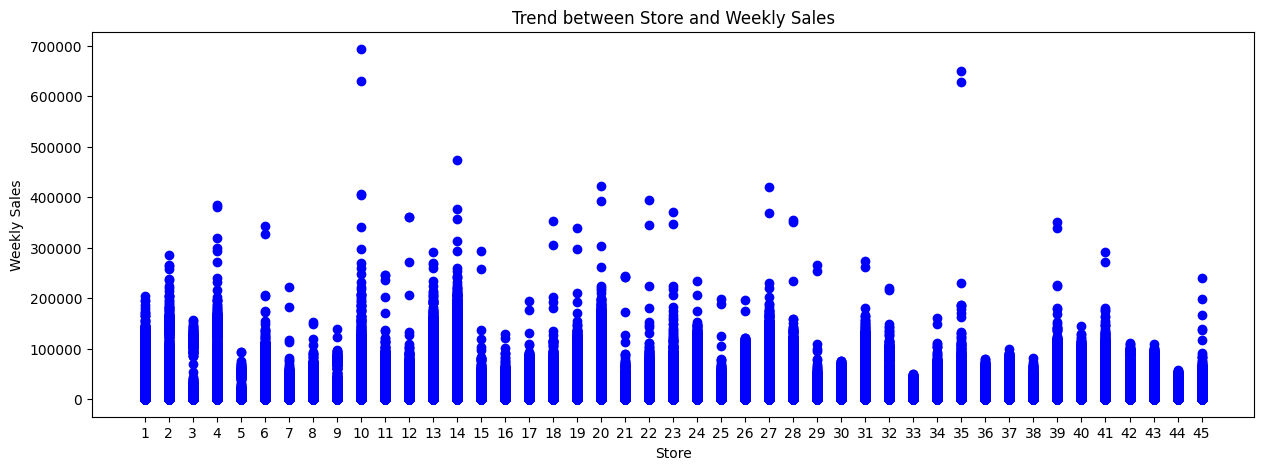

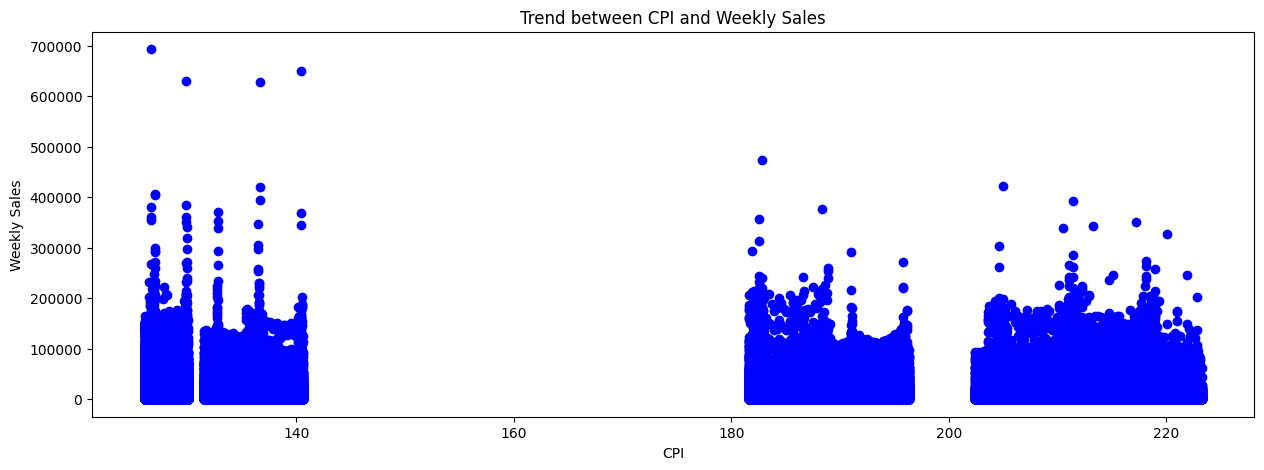

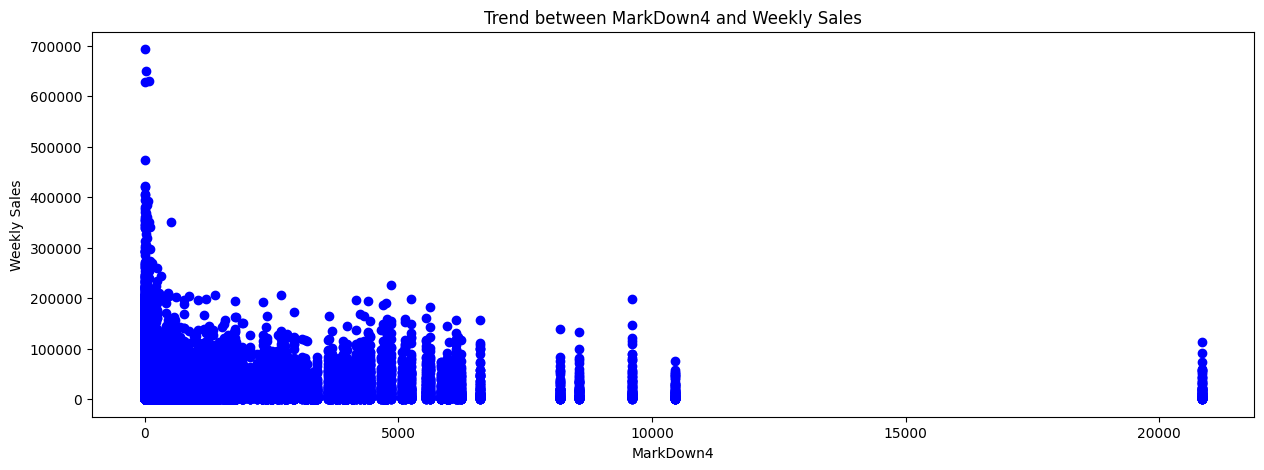

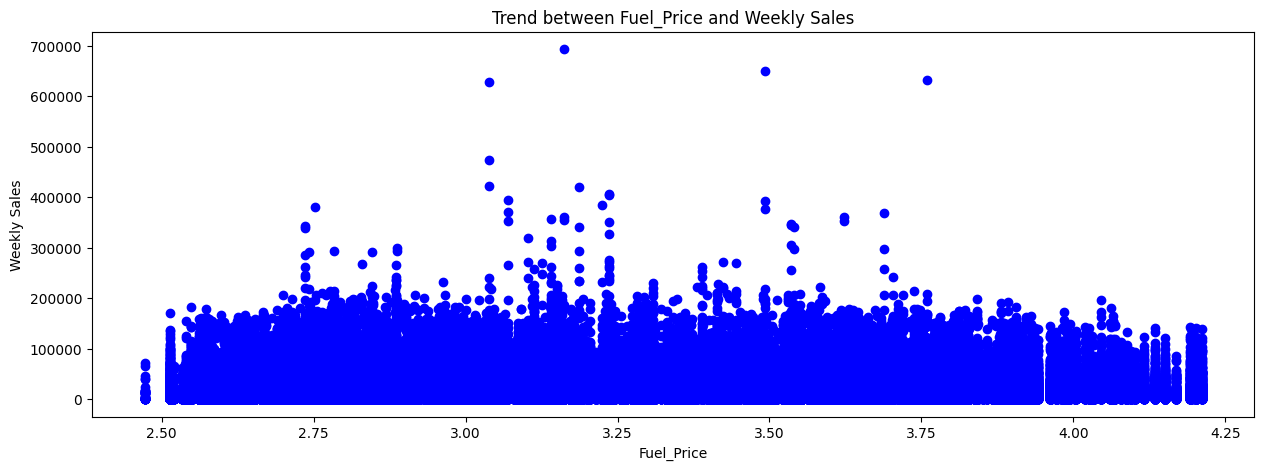

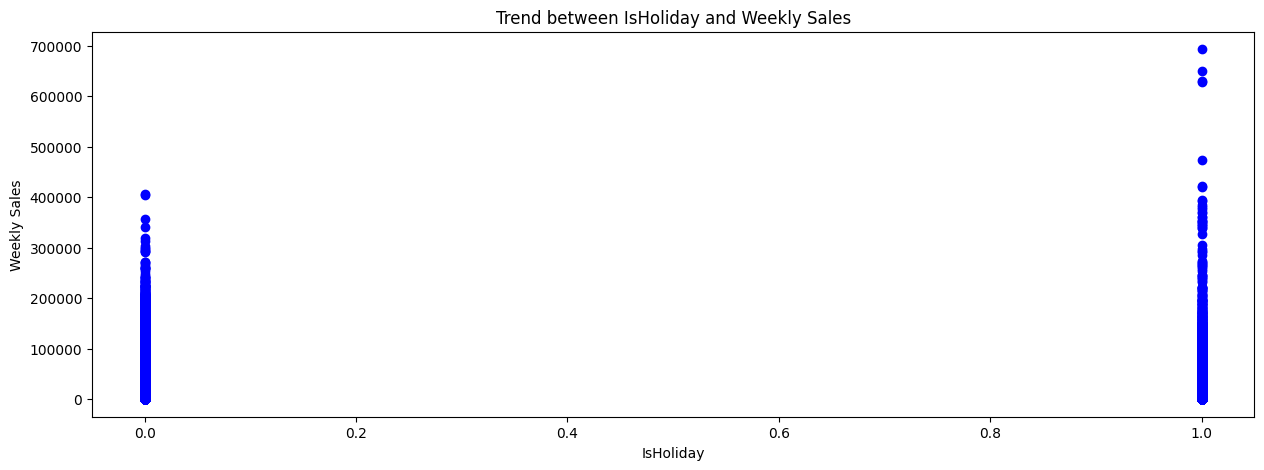

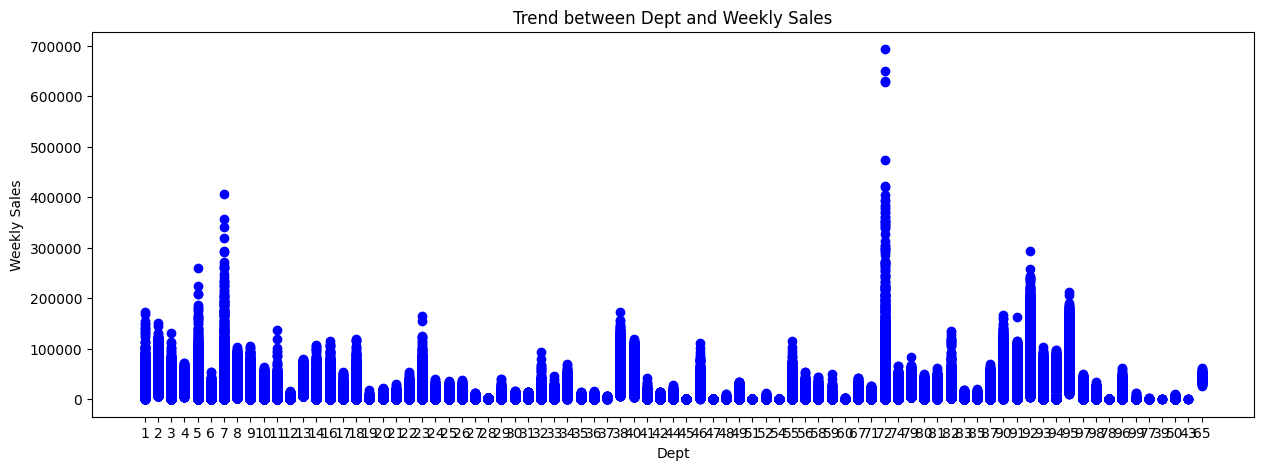

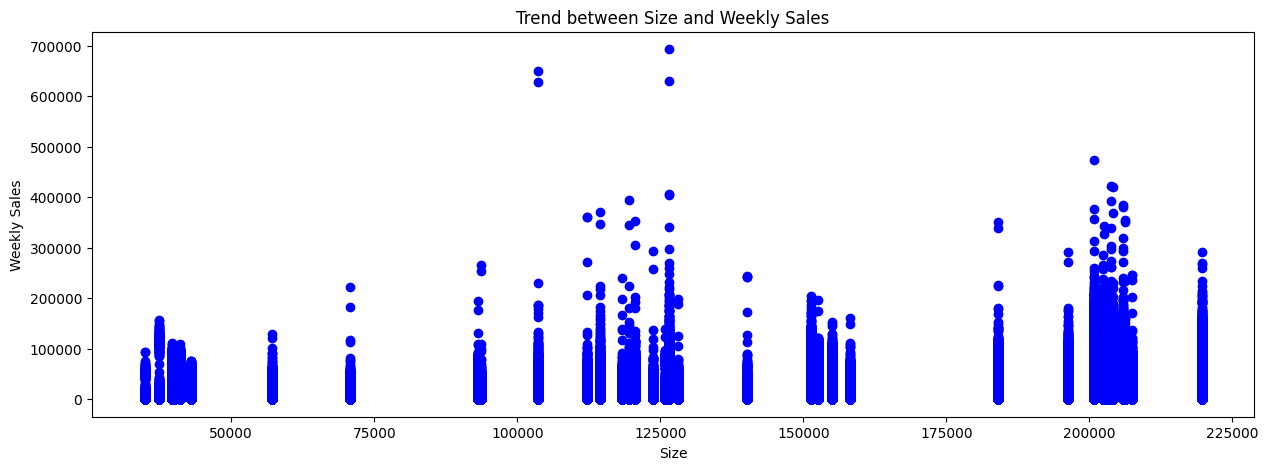

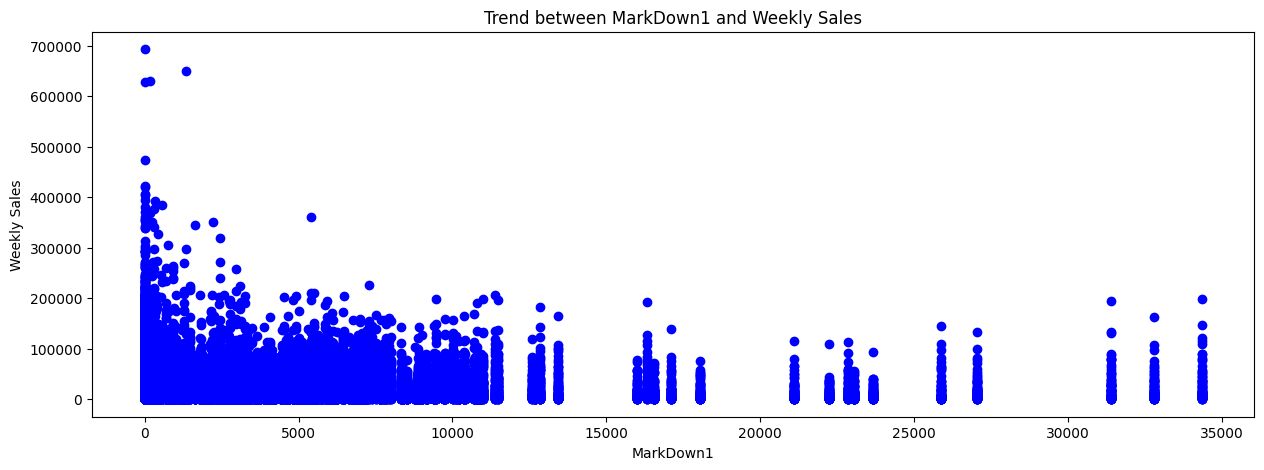

In [ ]:
# List of variables to check against 'Weekly_Sales', excluding 'Weekly_Sales' and 'Date'
var_list= [x for x in df_train.columns]
columnstodrop= ['Weekly_Sales', 'Date']
var_list= list(set(var_list).difference(set(columnstodrop)))

# Scatterplot to check the trends between the predictors and 'Weekly_Sales'
for varname in var_list:
  plt.figure(figsize= (15,5))
  plt.scatter(df_train[varname], df_train['Weekly_Sales'], color= 'blue')
  plt.xlabel(varname)
  plt.ylabel('Weekly Sales')
  plt.title(f'Trend between {varname} and Weekly Sales')
  plt.show()

### Sales Trends and Correlation Analysis

The aim of the next step is to analyze the relationship between the independent variables and the target variable (`Weekly_Sales`) while also observing sales trends over time. This analysis helps in identifying which variables have the strongest influence on sales, both from a time perspective (e.g., weekly, yearly trends) and across categorical variables like `Store` and `Dept`.

1. **Correlation Analysis**: The relationships between numeric variables and `Weekly_Sales` are assessed using a correlation table. This helps determine the most impactful features, allowing for better feature selection and model improvement.

2. **Time-Based Trends**: Weekly and yearly sales trends are examined to identify patterns, such as seasonal variations, holiday impacts, and year-on-year sales performance.

3. **Store and Department Performance**: Sales trends are broken down by `Store` and `Dept` to observe how different stores and departments perform over time, providing insights into high-performing or underperforming segments.

Understanding these trends and relationships is crucial for building accurate forecasting models and for making strategic business decisions.


In [ ]:
# Select only numeric columns for correlation
num_cols= df_train.select_dtypes(include= [np.number]).columns.tolist()

# Checking correlations betweent the target feateure and other features
all_corr= df_train[num_cols].corr().unstack().reset_index()
print('All Correlations Shape:', all_corr.shape)

# Filter for correlations with 'Weekly_Sales'
corr_table= all_corr[all_corr['level_1'] == 'Weekly_Sales']
corr_table= corr_table.loc[(corr_table['level_0'] != 'Weekly_Sales')]

# Renaming columns for clarity
corr_table.columns= ['var1', 'var2', 'corr_value']

# Adding absolute correlation values
corr_table['corr_abs']= corr_table['corr_value'].abs()

# Sorting the table by absolute correlation values
corr_table= corr_table.sort_values(by= ['corr_abs'], ascending= False)

# Display the correlation table
print('Correlation Table Shape:', corr_table.shape)
corr_table

All Correlations Shape: (144, 3)
Correlation Table Shape: (11, 4)


,var1,var2,corr_value,corr_abs
132,Size,Weekly_Sales,0.242929,0.242929
72,MarkDown3,Weekly_Sales,0.044642,0.044642
96,MarkDown5,Weekly_Sales,0.038685,0.038685
48,MarkDown1,Weekly_Sales,0.035576,0.035576
84,MarkDown4,Weekly_Sales,0.031970,0.031970
120,Unemployment,Weekly_Sales,-0.025631,0.025631
108,CPI,Weekly_Sales,-0.021871,0.021871
60,MarkDown2,Weekly_Sales,0.016028,0.016028
12,IsHoliday,Weekly_Sales,0.013925,0.013925
24,Temperature,Weekly_Sales,-0.007911,0.007911


In [ ]:
# Adding 'week_number' and 'year' columns
df_train['week_number']= df_train['Date'].dt.isocalendar().week
df_train['year']= df_train['Date'].dt.year

# Checking the holday weeks with the highest total sales
temper= df_train.groupby('Date', as_index= False).agg({'Weekly_Sales':'sum'})
print(temper['Weekly_Sales'].mean())

47371515.0689


In [ ]:
# Aggregating by 'Date', 'IsHoliday', 'week_number' and 'year' to check sales trends
temper= df_train.groupby(['Date', 'IsHoliday', 'week_number', 'year'], as_index= False).agg({'Weekly_Sales':'sum'})
temper.loc[temper['IsHoliday'] == 1].sort_values(by= ['Weekly_Sales'], ascending= False)

,Date,IsHoliday,week_number,year,Weekly_Sales
94,2011-11-25,1,47,2011,66593835.85
42,2010-11-26,1,47,2010,65821216.26
1,2010-02-12,1,6,2010,48336800.10
53,2011-02-11,1,6,2011,47336816.90
83,2011-09-09,1,36,2011,46763760.42
99,2011-12-30,1,52,2011,46044300.91
31,2010-09-10,1,36,2010,45635418.66
47,2010-12-31,1,52,2010,40434740.42


In [ ]:
# Checking the weeks with the highest total sales, most of which are non-holidays
temper.sort_values(by= ['Weekly_Sales'], ascending= False).head(20)

,Date,IsHoliday,week_number,year,Weekly_Sales
46,2010-12-24,0,51,2010,80931586.20
98,2011-12-23,0,51,2011,76999773.57
94,2011-11-25,1,47,2011,66593835.85
42,2010-11-26,1,47,2010,65821216.26
45,2010-12-17,0,50,2010,61821317.85
97,2011-12-16,0,50,2011,60086723.16
44,2010-12-10,0,49,2010,55667840.03
96,2011-12-09,0,49,2011,55561557.73
8,2010-04-02,0,13,2010,50424232.22
17,2010-06-04,0,22,2010,50188767.60


<Axes: title={'center': 'Total Juxtaposed Weekly Sales by Year'}, xlabel='week_number', ylabel='Weekly_Sales'>

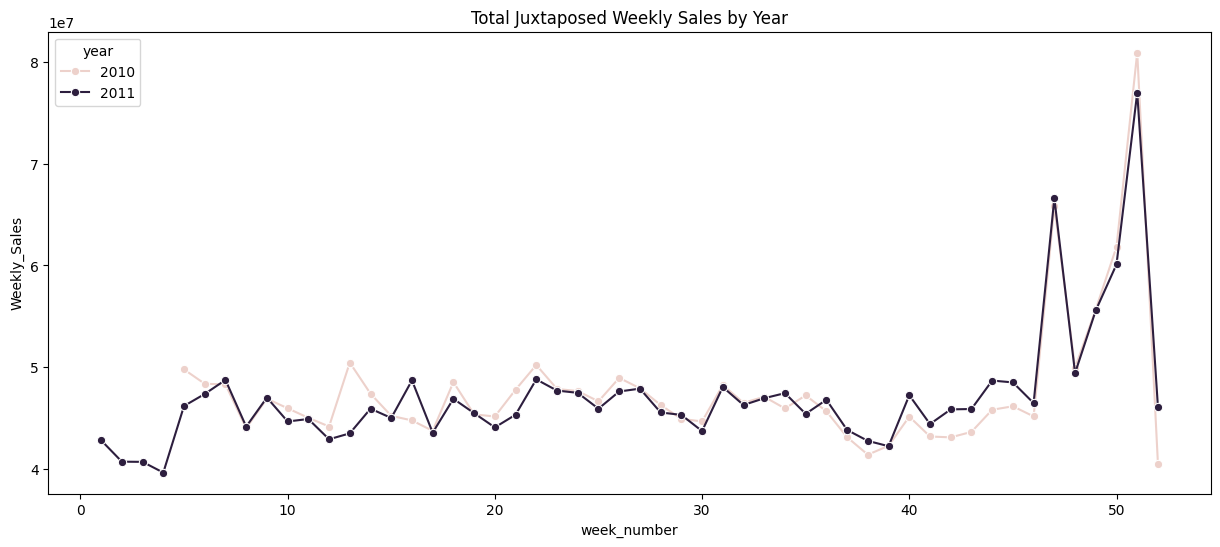

In [ ]:
# Checking 'Weekly_Sales' of different years juxtaposed
another_agg= df_train.groupby(['week_number', 'year', 'IsHoliday'], as_index= False).agg({'Weekly_Sales':'sum'})
plt.figure(figsize= (15,6))
plt.title('Total Juxtaposed Weekly Sales by Year')
sns.lineplot(data= another_agg, x= 'week_number', y= 'Weekly_Sales', hue= 'year', marker= 'o')

           Date Store  Weekly_Sales
2075 2010-12-24    14    3818686.45
2082 2010-12-24    20    3766687.43
2071 2010-12-24    10    3749057.69
4443 2011-12-23     4    3676388.98
2074 2010-12-24    13    3595903.20
           Date Dept  Weekly_Sales
3301 2010-11-26   72   10533640.92
7292 2011-11-25   72   10089874.40
3605 2010-12-24    7    6490778.39
3607 2010-12-24   72    6020196.03
7606 2011-12-23    7    5535941.35


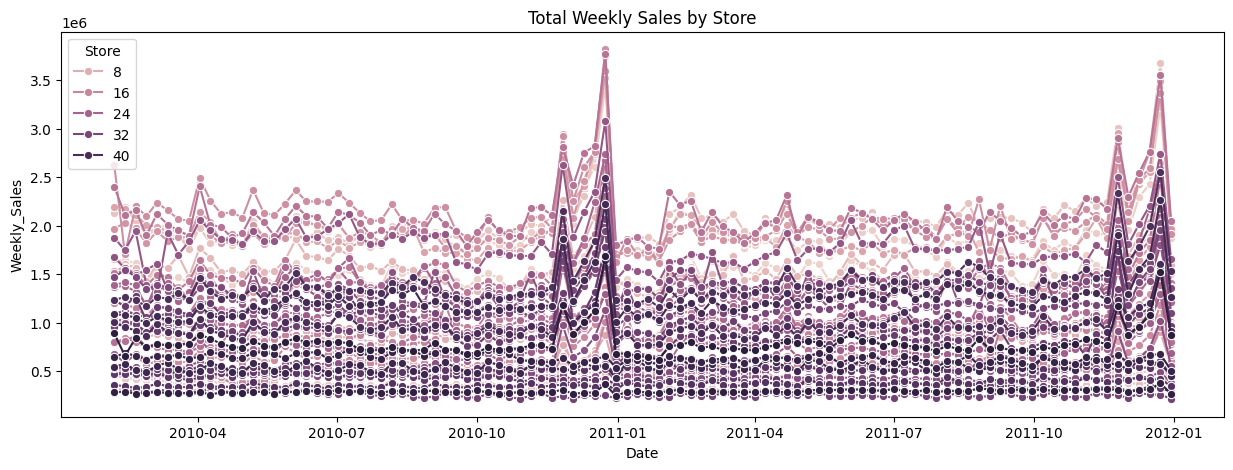

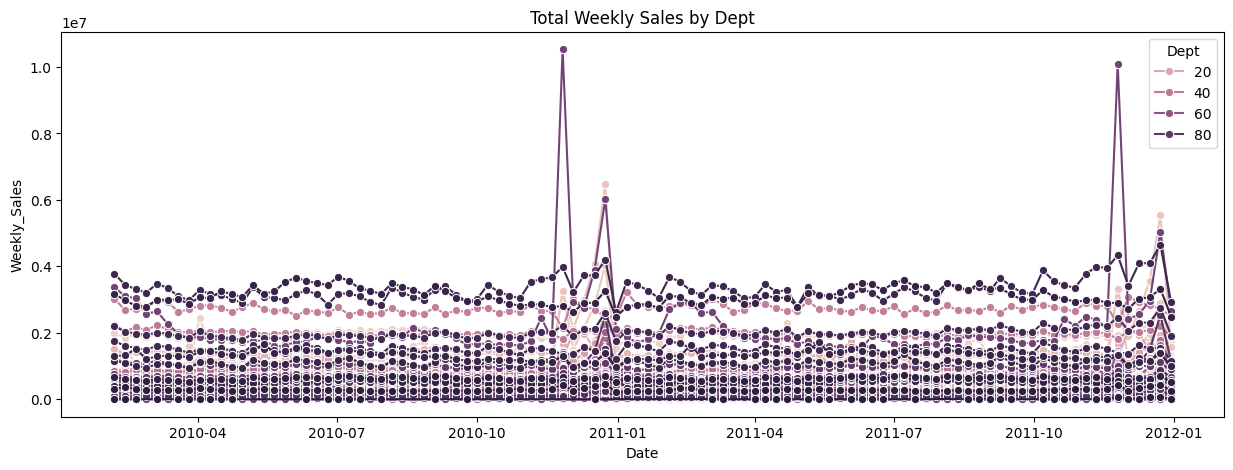

In [ ]:
# Checking total 'Weekly_Sales' by 'Store' and 'Dept'
for var in ['Store', 'Dept']:
  agg_temp= df_train.groupby(['Date', var], as_index= False).agg({'Weekly_Sales':'sum'})
  print(agg_temp.sort_values(by= 'Weekly_Sales', ascending= False).head())
  plt.figure(figsize= (15,5))
  plt.title('Total Weekly Sales by ' + var)
  agg_temp[var]= pd.to_numeric(agg_temp[var])
  sns.lineplot(data= agg_temp, x= 'Date', y= 'Weekly_Sales', hue= var, marker= 'o')

In [ ]:
# Checking 'Weekly_Sales' by 'Store' and 'Dept' juxtaposed by year and week
for var in ['Store', 'Dept']:
  another_agg= df_train.groupby([var, 'week_number', 'year', 'IsHoliday'], as_index= False).agg({'Weekly_Sales':'sum'})
  for idd in another_agg[var].unique():
    temper= another_agg.loc[another_agg[var] == idd]
    print(temper.shape)
    plt.figure(figsize= (15,5))
    plt.title(f'Total Weekly Juxtaposed Sales by {var} {idd}')
    sns.lineplot(data= temper, x= 'week_number', y= 'Weekly_Sales', hue= 'year', marker= 'o')

Output hidden; open in https://colab.research.google.com to view.

### Feature Engineering

The goal of this step is to create new features that can help improve model performance by capturing additional information about sales patterns. Specifically, holiday-related features are created to identify the impact of significant holidays and surrounding weeks on sales, as holidays often drive sales surges. Additionally, median sales for each store and department are calculated to provide a baseline for predicting future sales.

1. **Holiday Features**: New features are created to indicate whether a particular week is associated with key holidays (Christmas, Thanksgiving, Labor Day, Super Bowl). Additional binary features are generated for the weeks leading up to Christmas to capture the impact of the holiday season on sales trends.
   
2. **Sales Median by Store and Department**: The median `Weekly_Sales` for each store and department combination is calculated and added as a feature. This allows the model to have a reference point for typical sales behavior in each store and department, which is particularly useful for predicting future sales.

3. **Data Merging**: The newly created features are merged with both the training and test datasets, ensuring that the model has access to these additional variables during training and prediction.

By creating these holiday-related and sales median features, the analysis aims to improve the model's ability to predict sales patterns more accurately.


In [ ]:
# Check the data type of 'week_number' and convert it to integer if necessary
df_train['week_number']= df_train['week_number'].astype(int)

# Ensure 'IsHoliday' is treated as boolean (True/False)
df_train['IsHoliday']= df_train['IsHoliday'].astype(bool)

In [ ]:
# Marking the holiday names based on the week number
conditions= [
    (df_train['IsHoliday'] == False), # No holiday
    (df_train['week_number'] == 52), # Christmas
    (df_train['week_number'] == 47), # Thanksgiving
    (df_train['week_number'] == 36), # Labor Day
    (df_train['week_number'] == 6) # Superbowl
]

choices= ['no_holiday', 'christmas', 'thanksgiving', 'labor_day', 'super_bowl']
df_train['holiday_type']= np.select(conditions, choices, default= np.nan)

# Check the value counts for the newly created 'holiday_type' column
df_train['holiday_type'].value_counts()

,count
holiday_type,
no_holiday,269595
thanksgiving,5946
christmas,5909
super_bowl,5879
labor_day,5875


In [ ]:
# Define a function to create sales rush weeks
def season_variables(df):
  df['week_number']= df['Date'].dt.isocalendar().week.astype(int)
  df['year']= df['Date'].dt.year
  conditions= [
      (df['IsHoliday'] == False), # No holiday
      (df['week_number'] == 52), # Christmas
      (df['week_number'] == 47), # Thanksgiving
      (df['week_number'] == 36), # Labor Day
      (df['week_number'] == 6) # Superbowl
  ]

  choices= ['no_holiday', 'christmas', 'thanksgiving', 'labor_day', 'super_bowl']
  df['holiday_type']= np.select(conditions, choices, default= np.nan)
  print(df['holiday_type'].value_counts())

  # Creating additional features for Christmas week and weeks leading up to it
  christmas_df= pd.DataFrame(df[df['holiday_type'] == 'christmas']['Date'].unique())
  christmas_df.columns= ['christmas_week']
  christmas_df['minus1']= christmas_df['christmas_week'] - pd.to_timedelta(7, unit= 'd')
  christmas_df['minus2']= christmas_df['christmas_week'] - pd.to_timedelta(14, unit= 'd')
  christmas_df['minus3']= christmas_df['christmas_week'] - pd.to_timedelta(21, unit= 'd')

  # Creating binary variables for Christmas and weeks before it
  df['christmas_week']= np.where(df['Date'].isin(list(christmas_df['christmas_week'])), 1, 0)
  df['christmas_minus1']= np.where(df['Date'].isin(list(christmas_df['minus1'])), 1, 0)
  df['christmas_minus2']= np.where(df['Date'].isin(list(christmas_df['minus2'])), 1, 0)
  df['christmas_minus3']= np.where(df['Date'].isin(list(christmas_df['minus3'])), 1, 0)
  df['thanksgiving']= np.where(df['holiday_type'] == 'thanksgiving', 1, 0)

  # Print counts of created features
  print("Value Counts for 'christmas_week: ", df['christmas_week'].value_counts())
  print("Value Counts for 'christmas_minus1: ", df['christmas_minus1'].value_counts())
  print("Value Counts for 'christmas_minus2: ", df['christmas_minus2'].value_counts())
  print("Value Counts for 'christmas_minus3: ", df['christmas_minus3'].value_counts())
  print("Value Counts for 'thanksgiving: ", df['thanksgiving'].value_counts())

  return df

# Apply the function to both the train and test data
df_train= season_variables(df_train)
df_test= season_variables(df_test)

holiday_type
no_holiday      269595
thanksgiving      5946
christmas         5909
super_bowl        5879
labor_day         5875
Name: count, dtype: int64
Value Counts for 'christmas_week:  christmas_week
0    287295
1      5909
Name: count, dtype: int64
Value Counts for 'christmas_minus1:  christmas_minus1
0    287234
1      5970
Name: count, dtype: int64
Value Counts for 'christmas_minus2:  christmas_minus2
0    287251
1      5953
Name: count, dtype: int64
Value Counts for 'christmas_minus3:  christmas_minus3
0    287266
1      5938
Name: count, dtype: int64
Value Counts for 'thanksgiving:  thanksgiving
0    287258
1      5946
Name: count, dtype: int64
holiday_type
no_holiday    121057
super_bowl      2994
labor_day       2957
Name: count, dtype: int64
Value Counts for 'christmas_week:  christmas_week
0    127008
Name: count, dtype: int64
Value Counts for 'christmas_minus1:  christmas_minus1
0    127008
Name: count, dtype: int64
Value Counts for 'christmas_minus2:  christmas_minus2
0 

In [ ]:
# Create another feature: Median sales by 'Store' and 'Dept'
store_dept_median= df_train.groupby(['Store', 'Dept'], as_index= False).agg({'Weekly_Sales':'median'})
store_dept_median.columns= ['Store', 'Dept', 'Weekly_Sales_median']

# Merging the newly created median sales feature into train and test sets
df_train= pd.merge(df_train, store_dept_median, on= ['Store', 'Dept'], how= 'left')
df_test= pd.merge(df_test, store_dept_median, on= ['Store', 'Dept'], how= 'left')

In [ ]:
# Filling missing values for the new feature in the test data with the mean
df_test['Weekly_Sales_median'].fillna(df_test['Weekly_Sales_median'].mean(), inplace= True)

# Checking the final shape after merging
print('Train Data Shape: ', df_train.shape)
print('Test Data Shape: ', df_test.shape)

Train Data Shape:  (293204, 25)
Test Data Shape:  (127008, 25)


In [ ]:
# Examine the difference in the columns
print('Train Data Columns', df_train.columns)
print('Test Data Columns', df_test.columns)

Train Data Columns Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'week_number',
       'year', 'holiday_type', 'christmas_week', 'christmas_minus1',
       'christmas_minus2', 'christmas_minus3', 'thanksgiving',
       'Weekly_Sales_median'],
      dtype='object')
Test Data Columns Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'week_number',
       'year', 'holiday_type', 'christmas_week', 'christmas_minus1',
       'christmas_minus2', 'christmas_minus3', 'thanksgiving',
       'Weekly_Sales_median'],
      dtype='object')


In [ ]:
# Drop one of the redundant columns
df_test= df_test.drop(columns= ['Weekly_Sales_median_y'], errors= 'ignore')

# Rename 'Weekly_Sales_median_x' to 'Weekly_Sales_median'
df_test.rename(columns= {'Weekly_Sales_median_x':'Weekly_Sales_median'})

# Fill missing values in the test data for 'Weekly_Sales_median'
df_test['Weekly_Sales_median'].fillna(df_test['Weekly_Sales_median'].mean(), inplace= True)

# Check the shapes of the datasets
print('Train Data Shape: ', df_train.shape)
print('Test Data Shape: ', df_test.shape)

Train Data Shape:  (293204, 25)
Test Data Shape:  (127008, 25)


### Generating Sales Predictions

In the next step, two different approaches are employed to predict the sales for each combination of Store, Department, and Week. The first approach uses a combination of Store, Department, and Week to estimate sales based on historical data, capturing seasonal trends and the unique sales patterns of each store and department over time. The second approach provides a fallback prediction by using only the Department to estimate sales, which is helpful when certain Store-Department-Week combinations are missing from the training data.

After generating predictions, the function applies these two methods to the test data, first using the more specific Store-Department-Week-based predictions. For any combinations that cannot be predicted using this method, the fallback Department-only predictions are applied to ensure that every entry in the test data receives a sales prediction. This approach guarantees comprehensive predictions, even for combinations with incomplete data.


In [ ]:
# Prediction based on 'Store', 'Dept' and 'week_number'
sim_pred= df_train.groupby(['Store', 'Dept', 'week_number'], as_index= False).agg({'Weekly_Sales':['mean', 'count']})
print('Simple Prediction Shape: ', sim_pred.shape)

Simple Prediction Shape:  (155979, 5)


In [ ]:
# Adjusting the column names for clarity
sim_pred.columns= ['_'.join(x) for x in sim_pred.columns.ravel()]
sim_pred= sim_pred.drop(['Weekly_Sales_count'], axis= 1)
sim_pred.columns= ['Store', 'Dept', 'week_number', 'Sales_prediction']
sim_pred['prediction_type']= 1
sim_pred.head()

,Store,Dept,week_number,Sales_prediction,prediction_type
0,1,1,1,15984.24,1
1,1,1,2,17359.70,1
2,1,1,3,17341.47,1
3,1,1,4,18461.18,1
4,1,1,5,23295.13,1


In [ ]:
# Merging the test data with the 'sim_pred'
df_test= pd.merge(df_test, sim_pred, on= ['Store', 'Dept', 'week_number'], how= 'left')
print('Merged Test Data Shape: ', df_test.shape)

Merged Test Data Shape:  (127008, 27)


In [ ]:
# Prediction based on 'Dept'
sim_pred2= df_train.groupby(['Dept'], as_index= False).agg({'Weekly_Sales':['mean', 'count']})
print('Simple Prediction 2 Shape: ', sim_pred2.shape)

Simple Prediction 2 Shape:  (81, 3)


In [ ]:
# Adjust the column names for clarity
sim_pred2.columns= ['_'.join(x) for x in sim_pred2.columns.ravel()]
sim_pred2= sim_pred2.drop(['Weekly_Sales_count'], axis= 1)
sim_pred2.columns= ['Dept', 'Sales_prediction']
sim_pred2['prediction_type']= 2
sim_pred2.head()

,Dept,Sales_prediction,prediction_type
0,1,19598.410840,2
1,10,18246.069967,2
2,11,14668.411385,2
3,12,4151.166962,2
4,13,30624.612680,2


In [ ]:
# Define a function for the test data that applies the two simple predictions
def score_direct(df_to_score, pred_df1, pred_df2):

  # Extract 'week_number' from the 'Date' column
  df_to_score['week_number']= df_to_score['Date'].dt.isocalendar().week
  df_input= df_to_score[['Store', 'Dept', 'Date', 'week_number']]
  print('Input Data Shape: ', df_input.shape)

  # Verify if there is only 1 entrey per combination being used to predict
  print('Number of unique Store-Dept-Week combinations: ', df_input.groupby(['Store', 'Dept', 'week_number']).size().shape)

  # Use prediction 1 and separate combinations that remain unscored
  df_scored= pd.merge(df_input, pred_df1, on= ['Store', 'Dept', 'week_number'], how= 'left')

  # Separate out the scored and unscored data
  df_present= df_scored[~pd.isnull(df_scored['prediction_type'])]
  df_missed= df_scored[pd.isnull(df_scored['prediction_type'])]

  # Drop the unused prediction columns from the unscored data
  df_missed= df_missed.drop(['Sales_prediction', 'prediction_type'], axis= 1)

  # Using prediction 2 to score the unscored test data
  df_missed_scored= pd.merge(df_missed, pred_df2, on= ['Dept'], how= 'left')
  print('Number of missed entries after prediction 2: ', df_missed_scored['prediction_type'].isna().sum)

  # Combine the scored and missed scored data
  df_full_scored= pd.concat([df_present, df_missed_scored], axis= 0)
  print('Final Scored Data Shape: ', df_full_scored.shape)
  print('Prediction Type Value Counts: ', df_full_scored['prediction_type'].value_counts())

  return df_full_scored

In [ ]:
# Applying the scoring function to the test data
test_full_scored= score_direct(df_test, sim_pred, sim_pred2)

# Check the shape of the final scored test data
print('Scored Test Data Shape: ', test_full_scored.shape)

Input Data Shape:  (127008, 4)
Number of unique Store-Dept-Week combinations:  (127008,)
Number of missed entries after prediction 2:  <bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
2637    False
2638    False
2639    False
2640    False
2641    False
Name: prediction_type, Length: 2642, dtype: bool>
Final Scored Data Shape:  (127008, 6)
Prediction Type Value Counts:  prediction_type
1.0    124366
2.0      2642
Name: count, dtype: int64
Scored Test Data Shape:  (127008, 6)


### Random Forest Regression with Hyperparameter Tuning

Next, to predict weekly sales, a Random Forest Regressor is used. This model is chosen for its ability to handle complex, non-linear relationships between features. The model is first trained using hyperparameter tuning to optimize performance. Specifically, the number of trees (`n_estimators`) is adjusted through grid search, allowing the model to find the best configuration for accurate sales predictions.

Before training, one-hot encoding is applied to the categorical variable (`Type`), and highly correlated features (`MarkDown4` and `MarkDown5`) are removed to reduce redundancy. The target variable (`Weekly_Sales`) is separated from the features for both training and testing sets.

Once the model is trained, the importance of each feature is calculated, showing which variables have the most influence on predicting weekly sales. This step helps in understanding the key drivers of sales in the dataset.


In [ ]:
# One-hot encoding for the 'Type' categorical columns
cat_cols= ['Type']
df_train= pd.concat([df_train, pd.get_dummies(df_train[cat_cols], drop_first= True)], axis= 1)
df_test= pd.concat([df_test, pd.get_dummies(df_test[cat_cols], drop_first= True)], axis= 1)

In [ ]:
# Columns to drop for modeling
cols_drop= ['Type', 'Store', 'Dept', 'Weekly_Sales', 'holiday_type', 'week_number', 'year']

X_train= df_train.drop(cols_drop, axis= 1)
X_test= df_test.drop(cols_drop, axis= 1)

print('Train Set Shape: ', X_train.shape)
print('Test Set Shape: ', X_test.shape)

Train Set Shape:  (293204, 20)
Test Set Shape:  (127008, 22)


In [ ]:
# Compare columns in X_train and X_test
train_cols= set(X_train.columns)
test_cols= set(X_test.columns)

# Identify columns in X_test that are not in X_train
extra_cols_in_test= test_cols - train_cols
print("Extra columns in test set:", extra_cols_in_test)

# Identify columns in X_train that are not in X_test
missing_cols_in_test= train_cols - test_cols
print("Missing columns in test set:", missing_cols_in_test)

Extra columns in test set: {'Sales_prediction', 'prediction_type'}
Missing columns in test set: set()


In [ ]:
# Drop the extra, unnecessary columns 'Sales_prediction' and 'prediction_type' from the test set
X_test= X_test.drop(['Sales_prediction', 'prediction_type'], axis= 1)

# Check the shapes again
print('Train Set Shape: ', X_train.shape)
print('Test Set Shape: ', X_test.shape)

Train Set Shape:  (293204, 20)
Test Set Shape:  (127008, 20)


- Now everything is in order.

In [ ]:
# Dropping highly correlated variables
X_train= X_train.drop(['MarkDown4', 'MarkDown5'], axis= 1)
X_test= X_test.drop(['MarkDown4', 'MarkDown5'], axis= 1)

In [ ]:
# Define the target feature
y_train= df_train['Weekly_Sales']
y_test= df_test['Weekly_Sales']

In [ ]:
# Check for non-numeric columns and drop them
if 'Date' in X_train.columns:
  X_train= X_train.drop(['Date'], axis= 1)
if 'Date' in X_test.columns:
  X_test= X_test.drop(['Date'], axis= 1)

# Check data types of remaining columns
print(X_train.dtypes)

IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
CPI                    float64
Unemployment           float64
Size                     int64
christmas_week           int64
christmas_minus1         int64
christmas_minus2         int64
christmas_minus3         int64
thanksgiving             int64
Weekly_Sales_median    float64
Type_B                    bool
Type_C                    bool
dtype: object


In [ ]:
# Convert boolean columns to integers (0 and 1)
X_train['IsHoliday']= X_train['IsHoliday'].astype(int)
X_train['Type_B']= X_train['Type_B'].astype(int)
X_train['Type_C']= X_train['Type_C'].astype(int)

X_test['IsHoliday']= X_test['IsHoliday'].astype(int)
X_test['Type_B']= X_test['Type_B'].astype(int)
X_test['Type_C']= X_test['Type_C'].astype(int)

In [ ]:
# Initialize the RandomForestRegressor with hyperparameter tuning
aa= time.time()
rf= RandomForestRegressor(n_jobs= -1, max_depth= 5, random_state= 42)

# Define the parameter grid for hyperparametere tuning
param_grid= {'n_estimators':[50,100,200]}

# Perform GridSearchCV with cross-validation
cv_rf= GridSearchCV(estimator= rf, param_grid= param_grid, cv= 3)

# Fit the model to the train data
cv_rf.fit(X_train, y_train)

# Check for the best model after tuning
rf_best= cv_rf.best_estimator_
print('Best Random Forest Model: ', rf_best)
print('Model Tuning Time: ', time.time() - aa)

Best Random Forest Model:  RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1, random_state=42)
Model Tuning Time:  55.233468770980835


In [ ]:
# Define a function to calculate feature importance
def get_fi(modelname, dfname):

  # Extract feature importances from the trained model
  importance_list= pd.DataFrame(modelname.feature_importances_, columns= ['importance'])

  # Get the feature names from the DataFrame
  varnames_list= pd.DataFrame(dfname.columns.tolist(), columns= ['feature'])

  # Combine feature names with their corresponding importance values
  feature_importance= pd.concat([varnames_list, importance_list], axis= 1)

  # Sort the features by their importance
  feature_importance= feature_importance.sort_values(by= ['importance'], ascending= False)

  # Calculate cumulative importance to better understand top contributing features
  feature_importance['cum_importance']= feature_importance['importance'].cumsum()

  return feature_importance

In [ ]:
# Get feature importance from the best model
get_fi(rf_best, X_train)

,feature,importance,cum_importance
14,Weekly_Sales_median,9.887667e-01,0.988767
10,christmas_minus1,6.642961e-03,0.995410
5,MarkDown3,2.713246e-03,0.998123
13,thanksgiving,1.440787e-03,0.999564
8,Size,2.606776e-04,0.999824
15,Type_B,7.955870e-05,0.999904
7,Unemployment,6.226944e-05,0.999966
1,Temperature,1.766254e-05,0.999984
3,MarkDown1,1.042452e-05,0.999994
6,CPI,5.580825e-06,1.000000


### Feature Importance Analysis

The feature importance values indicate that `Weekly_Sales_median` is by far the most important feature, contributing almost 99% to the model's predictions. This suggests that past sales are a very strong predictor of future sales, which is expected in time series data like this. Other features such as `christmas_minus1`, `MarkDown3`, and `thanksgiving` have relatively small contributions, while many features such as `IsHoliday`, `MarkDown2`, `Fuel_Price`, and `Type_C` contribute almost nothing to the model.

#### Insights:
- **Dominant Feature**: `Weekly_Sales_median` dominates the model, meaning that the sales data from similar time periods (by store, dept) are most predictive.
- **Small Influences**: Features like `christmas_minus1`, markdowns, and holidays like `thanksgiving` still have some influence, but their importance is minor compared to `Weekly_Sales_median`.
- **Non-Influential Features**: A number of features (like `Type_C`, `IsHoliday`, `Fuel_Price`) have zero or negligible importance, suggesting they may not add predictive power in this model.



In [ ]:
print(df_train[['Store', 'Dept']].dtypes)

Store    object
Dept     object
dtype: object


In [ ]:
# Taking an example of sales data for a specific store and department for ARIMA modeling
part_data= df_train.loc[(df_train['Store'] == '13') & (df_train['Dept'] == '17'), ['Date', 'Weekly_Sales']]

# Convert 'Date' to datetime
part_data['Date']= pd.to_datetime(part_data['Date'])

# Set 'Date' as the index
part_data.index= part_data.Date

# Drop the 'Date' column
part_data= part_data.drop('Date', axis= 1)

# View 'part_data'
part_data.head()

,Weekly_Sales
Date,
2010-02-05,22419.66
2010-02-12,21524.01
2010-02-19,23997.80
2010-02-26,22936.01
2010-03-05,21831.50


Min Date in part_data:  2010-02-05 00:00:00
Max Date in part_data:  2011-12-30 00:00:00
Split Date:  2011-12-30 00:00:00
Particular Train Data Shape:  (99, 1)
Particular Test Data Shape:  (1, 1)


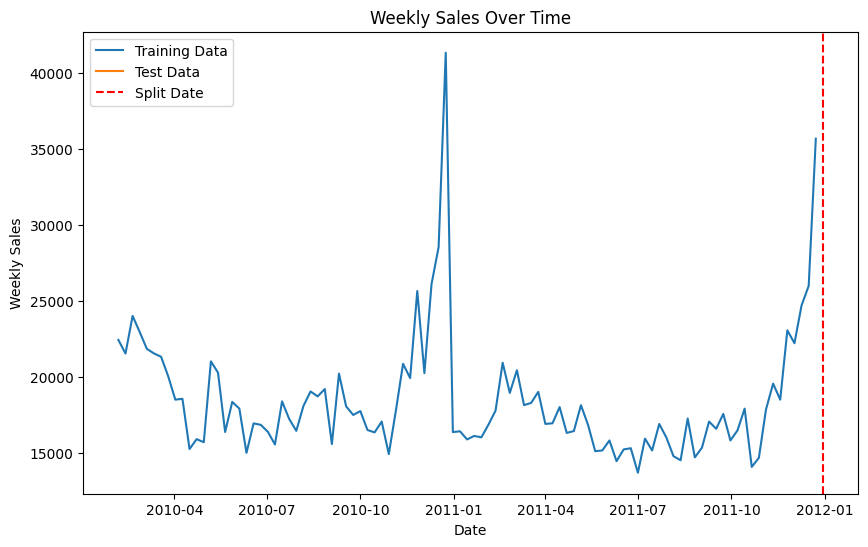

In [ ]:
# Predefined split_date
split_date = pd.to_datetime('2011-12-30')

# Check the minimum and maximum dates in the data
print("Min Date in part_data: ", part_data.index.min())
print("Max Date in part_data: ", part_data.index.max())
print("Split Date: ", split_date)

# Verify the distribution of dates and sales
part_data_train= part_data[part_data.index < split_date]
part_data_test= part_data[part_data.index >= split_date]

# Check the shapes
print('Particular Train Data Shape: ', part_data_train.shape)
print('Particular Test Data Shape: ', part_data_test.shape)

# Plot to visualize the data separation
plt.figure(figsize= (10,6))
plt.plot(part_data_train.index, part_data_train['Weekly_Sales'], label= 'Training Data')
plt.plot(part_data_test.index, part_data_test['Weekly_Sales'], label= 'Test Data')
plt.axvline(x= split_date, color= 'r', linestyle= '--', label= 'Split Date')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.legend()
plt.show()

In [ ]:
# Define an earlier split date
split_date= pd.to_datetime('2011-6-5')

# Re-split the data based on the new split date
part_data_train= part_data[part_data.index < split_date]
part_data_test= part_data[part_data.index >= split_date]

print('Train Data Shape:', part_data_train.shape)
print('Test Data Shape:', part_data_test.shape)

Train Data Shape: (70, 1)
Test Data Shape: (30, 1)


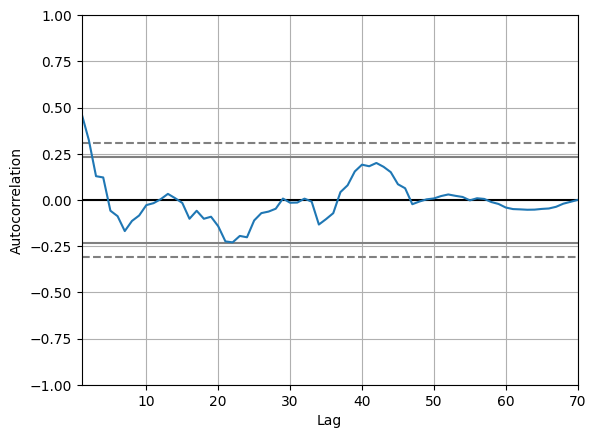

In [ ]:
# Visualize autocorrelations to understand potential lag relationships
autocorrelation_plot(part_data_train)
plt.show()

### Autocorrelation Plot Analysis

The autocorrelation plot examines the correlation of the time series with its past values over different lag intervals. The plot reveals how much the current value in the series depends on its previous values. A key observation from this plot is the initial positive autocorrelation, which decreases quickly, indicating short-term dependencies in the data. The absence of significant long-term correlations suggests that the time series may not exhibit strong seasonal or cyclical behavior over the longer term.

Values above the upper confidence limit indicate positive autocorrelation at certain lags, meaning past values have some influence on the current value. The oscillating pattern around zero further highlights that the dependencies diminish over time. This behavior aligns with expectations for retail sales data, where recent weeks influence the current week more than distant weeks.


### ARIMA Model

**ARIMA** stands for **AutoRegressive Integrated Moving Average** and is a popular time series forecasting method that captures both autoregressive (AR) and moving average (MA) components, as well as trends through differencing (the 'I' component). ARIMA is particularly useful for time series data where patterns like trends and lags are key factors in predicting future values.

- **Autoregressive (AR) part:** This uses the dependency between an observation and a number of lagged observations.
- **Integrated (I) part:** This part involves differencing the observations (subtracting an observation from the previous observation) to make the series stationary, which is essential for many time series models.
- **Moving Average (MA) part:** This models the error of the forecast as a linear combination of error terms from past forecasts.

#### Why ARIMA Was Chosen

ARIMA was selected for this analysis due to its ability to model the autocorrelations present in the sales data. The time series exhibited short-term dependencies (as seen in the autocorrelation plot), which ARIMA effectively captures with its autoregressive component. The integrated part of ARIMA accounts for the trend over time, making the data stationary if needed. Since there is no evident seasonality in the data, a seasonal ARIMA (SARIMA) wasn't necessary.

Additionally, ARIMA allows for hyperparameter tuning using components such as the number of AR terms (p), the degree of differencing (d), and the number of MA terms (q). This flexibility makes it suitable for handling the non-seasonal sales data in retail.

#### Why ARIMA Works for This Dataset

In this case, retail sales data is generally driven by recent trends rather than long-term, repeated seasonal patterns. ARIMA works well here because:
- It models the short-term dependencies effectively.
- The sales data does not exhibit strong seasonal characteristics, so the simpler ARIMA model suffices without requiring seasonal adjustments.
- With hyperparameter tuning, the model can adjust to the optimal number of lagged terms and error terms to improve forecast accuracy.

By leveraging ARIMA, the forecasting model provides a good fit for the structure of the sales data, capturing both trends and short-term fluctuations to make accurate future predictions.


In [ ]:
# Fit the ARIMA model
model= ARIMA(part_data_train, order= (0,1,0))
model_fit= model.fit()
print('ARIMA Model Summary: ', model_fit.summary())

ARIMA Model Summary:                                 SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                   70
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -669.945
Date:                Wed, 11 Sep 2024   AIC                           1341.890
Time:                        16:32:02   BIC                           1344.124
Sample:                    02-05-2010   HQIC                          1342.776
                         - 06-03-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.566e+07   7.71e+05     20.315      0.000    1.41e+07    1.72e+07
Ljung-Box (L1) (Q):                  10.07   Jarque-Bera (JB):              1365.07
Prob(Q):                 

### ARIMA Model Summary Analysis

The ARIMA(0,1,0) model was fitted to the sales data with 70 observations. This model is a simple differenced model with no autoregressive (AR) or moving average (MA) terms.

**Key Metrics:**
- **Log Likelihood:** -669.945, a measure of the model's fit to the data. Higher values (less negative) indicate better fit.
- **AIC (Akaike Information Criterion):** 1341.890, used to compare models. Lower AIC values indicate a better model.
- **BIC (Bayesian Information Criterion):** 1344.124, similar to AIC but with a penalty for model complexity. Again, lower values are preferred.

**Coefficients:**
- **sigma^2 (Variance of Residuals):** The estimated variance of the error term is 1.566e+07, suggesting some volatility in the data.

**Diagnostic Statistics:**
- **Ljung-Box Q (L1):** The p-value of the Ljung-Box test is very small, indicating that there might still be some autocorrelation left in the residuals.
- **Jarque-Bera (JB) Test:** The JB statistic and a p-value of near 0 indicate that the residuals are not normally distributed, which may affect forecast reliability.
- **Skewness and Kurtosis:** The residuals show significant skewness (-2.93) and extremely high kurtosis (23.99), indicating heavy-tailed, non-normal distribution.

Although the model fits the data and captures the overall trend, the diagnostic statistics suggest some issues with residuals' distribution and autocorrelation. These should be considered when interpreting the forecast results, and more complex models could be explored for further improvement.

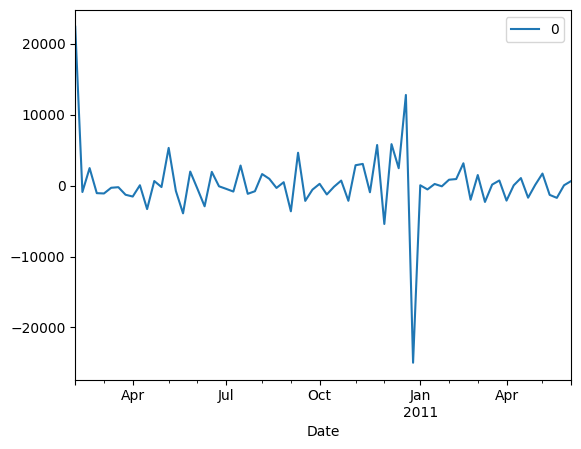

In [ ]:
# Plot the residuals to evaluate the model
residuals= pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

### Residuals Plot Analysis

The residuals plot visualizes the difference between the observed and predicted values from the ARIMA model over time. This helps to evaluate how well the model fits the data and whether there are patterns that suggest room for improvement.

**Key Observations:**
- The residuals fluctuate around zero, indicating that the model's predictions are relatively unbiased overall.
- However, there is a significant spike in the residuals around December 2010, indicating that the model struggled to predict sales during that period.
- Outside of the spike, the residuals appear to be fairly consistent, but there is still some variance, suggesting that the model does not perfectly capture all the underlying patterns in the data.



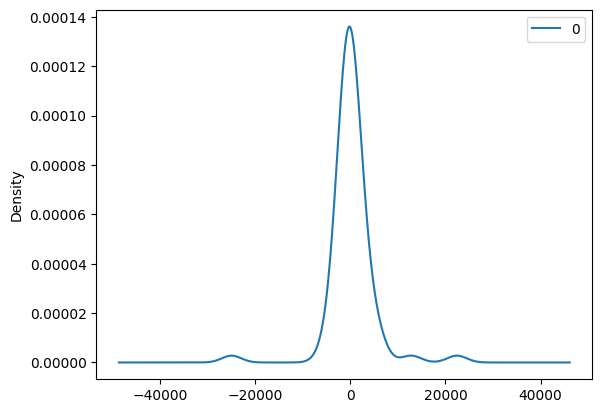

In [ ]:
# Plot the distribution of residuals
residuals.plot(kind= 'kde')
plt.show()

In [ ]:
# Residual summary statistics
residuals.describe()

,0
count,70.000000
mean,225.685714
std,4807.821966
min,-24984.130000
25%,-1143.345000
50%,-94.300000
75%,1041.180000
max,22419.660000


In [ ]:
# Hyperparameter tuning for ARIMA model using pmdarima
auto_model= auto_arima(part_data_train, start_p= 1, d= 0, start_q= 1, max_p= 3, start_P= 0, seasonal= False, trace= 'True', error_action= 'ignore')
auto_model.fit(part_data_train)

# Display the best model
print(auto_model)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1355.298, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1580.919, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1365.714, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1515.379, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1356.359, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1465.727, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1357.894, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1358.873, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1345.118, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1350.187, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1343.787, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1359.091, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1344.344, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : 

In [ ]:
# Make predictions using the tuned ARIMA model
test_arima= auto_model.predict(n_periods= len(part_data_test))

In [ ]:
# Splitting the sales data into train and test set for ARIMA model
sales_data_train= df_train[['Store', 'Dept', 'Date', 'Weekly_Sales']]
sales_data_test= df_test[['Store', 'Dept', 'Date', 'Weekly_Sales']]

# Check the number of records for each 'Store' and 'Dept' combination
temper= sales_data_train.groupby(['Store', 'Dept'], as_index= False).agg({'Date':'count'})
temper= temper.rename(columns= {'Date':'counter'})
temper.head()

,Store,Dept,counter
0,1,1,100
1,1,10,100
2,1,11,100
3,1,12,100
4,1,13,100


In [ ]:
# Grouping to see how many stores and departments have different number of records
temper2= temper.groupby(['counter'], as_index= False).agg({'Store':'count'})
temper2, temper.shape

(    counter  Store
 0         1     40
 1         2     40
 2         3     21
 3         4     29
 4         5     14
 ..      ...    ...
 93       96      6
 94       97      9
 95       98     23
 96       99     31
 97      100   2654
 
 [98 rows x 2 columns],
 (3292, 3))

In [ ]:
# Filter data based on the minimum number of records required for ARIMA
min_data_points= 50
combinations= sales_data_train.groupby(['Store', 'Dept']).agg({'Date': 'count'}).reset_index()
valid_combos= combinations[combinations['Date'] >= min_data_points]

# Merge valid combinations back to filter train and test data
filtered_train= pd.merge(sales_data_train, valid_combos[['Store', 'Dept']], on= ['Store', 'Dept'], how= 'inner')
filtered_test= pd.merge(sales_data_test, valid_combos[['Store', 'Dept']], on= ['Store', 'Dept'], how= 'inner')

print(f"Filtered Train Data Shape: {filtered_train.shape}")
print(f"Filtered Test Data Shape: {filtered_test.shape}")

Filtered Train Data Shape: (288640, 4)
Filtered Test Data Shape: (123479, 4)


In [ ]:
# Apply ARIMA on filtered data
def arima_modeler(filtered_train, filtered_test):
    all_scores= pd.DataFrame(columns=['score'])

    for i, row in valid_combos.iterrows():
        store_id = row['Store']
        dept_id = row['Dept']
        print(f'Running ARIMA for Store {store_id} and Dept {dept_id}')

        # Filter data for each combination
        particular_data_train= filtered_train[(filtered_train['Store'] == store_id) & (filtered_train['Dept'] == dept_id)]
        particular_data_test= filtered_test[(filtered_test['Store'] == store_id) & (filtered_test['Dept'] == dept_id)]

        # Ensure there's enough data
        if len(particular_data_train) < 50:  # Minimum data points requirement for ARIMA
            print(f'Skipping Store {store_id} and Dept {dept_id} due to insufficient data.')
            continue

        # Apply ARIMA
        try:
            auto_model= auto_arima(particular_data_train['Weekly_Sales'], start_p= 1, d= 0, start_q= 1, max_p= 3, max_q= 3, start_P= 0, trace= True)
            auto_model.fit(particular_data_train['Weekly_Sales'])
            test_arima= auto_model.predict(n_periods=len(particular_data_test))

            # Store predictions
            test_arima_df= pd.DataFrame(test_arima, columns=['score'])
            all_scores= pd.concat([all_scores, test_arima_df], axis=0)
        except Exception as e:
            print(f'ARIMA failed for Store {store_id} and Dept {dept_id}: {e}')

    return all_scores

# Run ARIMA modeler
predicted_scores= arima_modeler(filtered_train, filtered_test)

print(f'ARIMA Scored Data Shape: {predicted_scores.shape}')

Streaming output truncated to the last 5000 lines.
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1528.185, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1525.391, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.392 seconds
Running ARIMA for Store 45 and Dept 95
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1979.999, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2015.751, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1987.820, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2000.246, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2462.437, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1977.952, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1980.367, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1977.211, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1976.040, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Be

In [162]:
# Merge ARIMA predictions with the test data
filtered_test= filtered_test.reset_index(drop=True)
predicted_scores= predicted_scores.reset_index(drop=True)

# Concatenate the test data with the ARIMA predictions (ensure alignment in length)
fullyscored_test_arima= pd.concat([filtered_test, predicted_scores], axis=1)

# Check the shape of the fully scored test data
print(f'Fully Scored Test Data (ARIMA): {fullyscored_test_arima.shape}')

Fully Scored Test Data (ARIMA): (123479, 5)


In [163]:
# Handle missing ARIMA predictions
sales_data_test_missing= fullyscored_test_arima.loc[pd.isnull(fullyscored_test_arima['score'])]

# Merge missing data with simpler department-level predictions
sales_data_test_mp= pd.merge(sales_data_test_missing.drop('score', axis=1 ), sim_pred2.rename(columns= {'Sales_prediction': 'score'}), on= 'Dept')

# Drop 'prediction_type' from the merged data
sales_data_test_mp.drop('prediction_type', axis= 1, inplace= True)

# Concatenate the ARIMA scored data with the missing data filled in
fullyscored_test_arima= pd.concat([fullyscored_test_arima, sales_data_test_mp], axis= 0)

# Check the final shape of the fully scored test data
print(f'Final Fully Scored Test Data: {fullyscored_test_arima.shape}')

Final Fully Scored Test Data: (123479, 5)


In [164]:
# Define a function to score Random Forest predictions
def rf_scorer(X_df, Y_df, model_name):
    """
    Obtain the prediction from Random Forest and compare it with the actual Weekly Sales.
    """
    scored_rf= pd.DataFrame({'Sales_prediction': model_name.predict(X_df)})
    scored_actuals_rf= pd.concat([scored_rf, Y_df.reset_index()], axis= 1)
    scored_actuals_rf= scored_actuals_rf.drop(['index'], axis= 1)
    scored_actuals_rf['error_abs_rf']= (scored_actuals_rf['Sales_prediction'] - scored_actuals_rf['Weekly_Sales']).abs()
    return scored_actuals_rf

# Applying Random Forest scoring
test_rf= rf_scorer(X_test, y_test, rf_best)

# Calculating absolute errors for ARIMA predictions
fullyscored_test_arima['error_abs_ar']= (fullyscored_test_arima['Weekly_Sales'] - fullyscored_test_arima['score']).abs()

# Mean Absolute Error (MAE) Comparison
print("MAE Random Forest: ", mean_absolute_error(test_rf['Weekly_Sales'], test_rf['Sales_prediction']))
print("MAE ARIMA: ", mean_absolute_error(fullyscored_test_arima['Weekly_Sales'], fullyscored_test_arima['score']))

# Root Mean Squared Error (RMSE) Comparison
print("RMSE Random Forest: ", math.sqrt(mean_squared_error(test_rf['Weekly_Sales'], test_rf['Sales_prediction'])))
print("RMSE ARIMA: ", math.sqrt(mean_squared_error(fullyscored_test_arima['Weekly_Sales'], fullyscored_test_arima['score'])))

MAE Random Forest:  2615.6062956744354
MAE ARIMA:  19070.698848818716
RMSE Random Forest:  5183.647218460856
RMSE ARIMA:  30332.460204338324


### Model Performance Analysis: Random Forest vs ARIMA

In evaluating the performance of predictive models, **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** are commonly used metrics. Both capture different aspects of prediction error and provide insights into how well the model performs.

- **Mean Absolute Error (MAE)**:  
  MAE measures the average magnitude of errors between the predicted and actual values, regardless of direction (i.e., whether the prediction was an overestimate or underestimate). It gives an intuitive sense of how much error, on average, can be expected from the model’s predictions. MAE is especially useful when all errors are weighted equally in importance. In this context, MAE captures how far the predicted weekly sales deviate from the actual sales, on average.

- **Root Mean Squared Error (RMSE)**:  
  RMSE, on the other hand, is similar to MAE but gives greater weight to larger errors due to the squaring of the error terms before averaging. This metric is sensitive to outliers and larger errors, making it ideal for highlighting when a model has larger deviations from actual values. It is useful when we want to penalize larger errors more heavily. In this scenario, RMSE captures not only the average error in weekly sales prediction but also emphasizes cases where predictions deviate significantly from the actual values.

These metrics were chosen because they provide a clear sense of the average prediction error (MAE) and how severe those errors can be, especially larger ones (RMSE). By analyzing both, we get a more comprehensive understanding of the model’s predictive capabilities.

#### Results:

- **MAE Random Forest**: 2615.61  
  The relatively low MAE value for the Random Forest model indicates that the average difference between the predicted and actual weekly sales is approximately 2615. This suggests that the Random Forest model provides better predictive accuracy compared to the ARIMA model.

- **MAE ARIMA**: 19070.70  
  The ARIMA model has a much higher MAE compared to Random Forest, with an average error of 19,070. This indicates that the ARIMA model struggles to predict weekly sales accurately and tends to have larger deviations from the actual values.

- **RMSE Random Forest**: 5183.65  
  The RMSE value for the Random Forest model is 5183, which reflects the presence of some larger prediction errors. RMSE is higher than the MAE due to the square of errors in its calculation, but it remains significantly lower than that of ARIMA, indicating a better fit for the Random Forest model.

- **RMSE ARIMA**: 30332.46  
  The ARIMA model's RMSE is 30,332, showing that it has large error magnitudes and higher variance in its predictions. The much larger RMSE compared to MAE for ARIMA highlights the presence of significant prediction errors, demonstrating its limitations compared to the Random Forest model.

The Random Forest model outperforms the ARIMA model across both MAE and RMSE metrics. While the Random Forest model shows a more consistent and lower error rate, the ARIMA model exhibits much larger errors. This suggests that Random Forest is a better choice for predicting weekly sales in this context, as it balances both small and large errors more effectively.


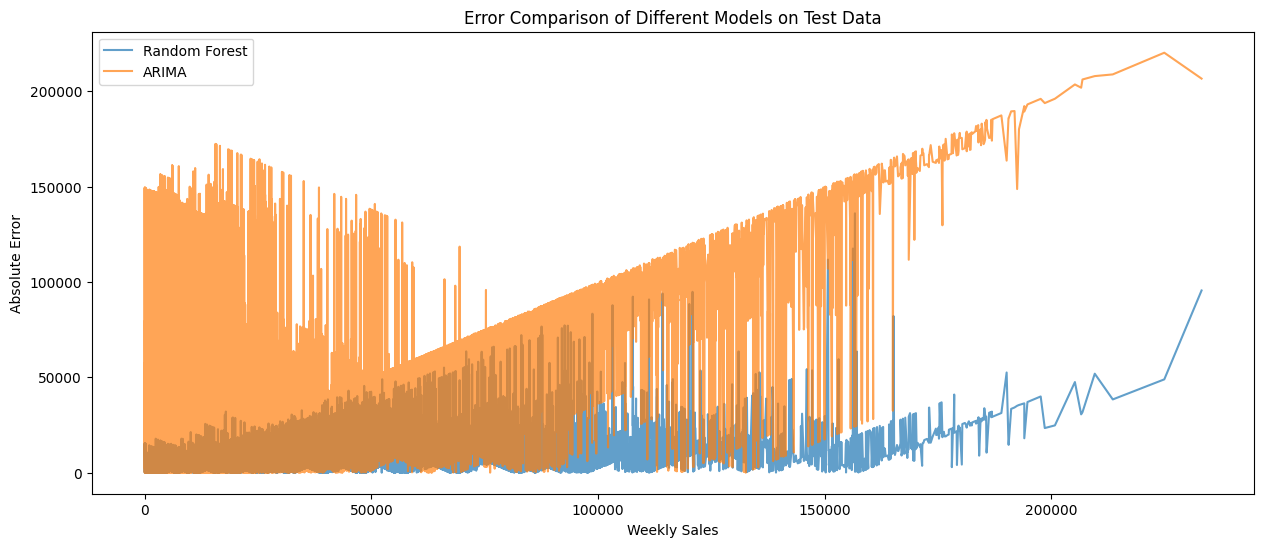

In [165]:
# Sort data by Weekly Sales for plotting
temper2= test_rf.sort_values(by= ['Weekly_Sales'])
temper3= fullyscored_test_arima.sort_values(by= ['Weekly_Sales'])

# Plot absolute errors for each model
plt.figure(figsize= (15,6))
plt.title('Error Comparison of Different Models on Test Data')
plt.xlabel('Weekly Sales')
plt.ylabel('Absolute Error')

plt.plot(temper2['Weekly_Sales'], temper2['error_abs_rf'], label= 'Random Forest', alpha= 0.7)
plt.plot(temper3['Weekly_Sales'], temper3['error_abs_ar'], label= 'ARIMA', alpha= 0.7)
plt.legend()
plt.show()

### Error Comparison of Different Models on Test Data

The plot above shows the **absolute error** of the Random Forest and ARIMA models compared against the **weekly sales**. The **x-axis** represents the weekly sales, and the **y-axis** represents the absolute error. The two lines in the graph represent the prediction errors for both models:

- **Random Forest (Blue Line)**:  
  The Random Forest model demonstrates a relatively low error across the majority of weekly sales values. Its error increases slightly as the weekly sales increase, but it remains consistently lower compared to the ARIMA model. This highlights the robustness and accuracy of the Random Forest model in handling this dataset, even as the sales values increase.

- **ARIMA (Orange Line)**:  
  The ARIMA model, on the other hand, shows significantly higher error throughout the weekly sales range. As the weekly sales increase, the error escalates drastically, indicating that ARIMA struggles with predicting high sales values accurately. The large and consistent increase in error for ARIMA reflects the model’s limitations in capturing the underlying patterns in the data, particularly for larger sales values.

#### Analysis:
- The Random Forest model clearly outperforms the ARIMA model in terms of predictive accuracy, especially for higher sales values.
- The steep rise in the ARIMA model's error suggests it is less suited for capturing the complexities of this dataset, while the Random Forest model maintains more stable and lower errors.
  
This comparison reinforces that **Random Forest** is a more reliable model for this prediction task, offering more precise predictions with smaller errors across the entire range of sales values.


## **Conclusion**

This analysis explored the task of predicting weekly Walmart sales using two different machine learning models: **Random Forest Regression** and **ARIMA**. The aim was to evaluate which model could better capture the underlying patterns in the sales data and provide accurate predictions.

### Key Findings:
1. **Data Preparation**:  
   The data was carefully preprocessed, including handling missing values, merging datasets, and engineering important features like holiday indicators and markdowns. Both the train and test datasets were aligned in terms of features for consistency, ensuring the models were trained and tested under comparable conditions.

2. **Random Forest Model**:  
   The **Random Forest** model was trained with hyperparameter tuning through **GridSearchCV** to optimize the number of estimators and depth of the trees. This model demonstrated strong performance across several metrics:
   - **Mean Absolute Error (MAE)**: 2,615
   - **Root Mean Squared Error (RMSE)**: 5,183  
   
   These metrics indicate that the Random Forest model was able to capture most of the sales patterns effectively, producing relatively low prediction errors. The **absolute error** plot further confirmed the model's stability across different sales levels, particularly when dealing with larger sales values. For Walmart, this translates to more accurate sales forecasts, enabling better inventory management and reduction of stockouts or overstock situations, which directly affects operational efficiency and customer satisfaction.

3. **ARIMA Model**:  
   ARIMA, a well-known time series forecasting method, was also applied. However, its performance was less impressive:
   - **Mean Absolute Error (MAE)**: 19,070
   - **Root Mean Squared Error (RMSE)**: 30,332
   
   Despite ARIMA's historical effectiveness in time series forecasting, it struggled with this dataset, particularly as sales values increased. The error comparison plot showed that ARIMA's absolute error increased significantly for larger sales figures, revealing its limitations in this context. For Walmart, this indicates that ARIMA may lead to inaccurate forecasts during critical high-sales periods like holiday seasons, potentially resulting in missed revenue opportunities or supply chain inefficiencies.

4. **Model Comparison**:  
   The **Random Forest** model outperformed ARIMA in nearly every metric, showing significantly lower errors and greater predictive accuracy. The **error comparison plot** between Random Forest and ARIMA clearly illustrated Random Forest's superiority, particularly for larger sales values, where ARIMA's errors ballooned while Random Forest maintained reasonable accuracy.

### What These Numbers Mean for Walmart Sales Prediction:
The results from this analysis suggest that **Random Forest** is better suited for predicting Walmart's weekly sales compared to traditional time series models like ARIMA. The lower **MAE** and **RMSE** of Random Forest show that it can provide Walmart with more accurate and consistent predictions, especially during periods of fluctuating sales, such as holiday seasons or promotional events.

For Walmart, this means:
- **Improved Inventory Management**: With more accurate sales forecasts, Walmart can optimize stock levels in stores, ensuring that popular products are sufficiently stocked while avoiding overstock of slow-moving items. This leads to cost savings on warehousing and transportation, as well as a better shopping experience for customers due to fewer stockouts.
- **Efficient Resource Allocation**: Accurate sales predictions allow Walmart to allocate labor and other resources more efficiently, ensuring the right staffing levels in stores, especially during high-demand periods.
- **Better Strategic Planning**: Understanding future sales trends with greater accuracy helps Walmart make informed decisions around pricing, promotions, and supply chain operations.

### Business Recommendations:
1. **Adopt Random Forest for Sales Prediction**: The results demonstrate that Random Forest outperforms ARIMA for this specific dataset and business problem. Walmart should consider integrating Random Forest (or similar ensemble learning models) into its forecasting pipeline to improve sales prediction accuracy across all stores and departments.

2. **Real-Time Forecast Adjustments**: Given the dynamic nature of retail sales, Walmart should implement a system for real-time adjustments to the forecasts. This could involve updating the model as new data comes in (e.g., weekly), allowing the model to account for sudden changes in consumer demand.

3. **Data Enrichment**: While Random Forest performed well with the available features, additional features (such as external economic indicators, consumer sentiment data, or competitor pricing) could be incorporated to further improve forecast accuracy. This data could help capture external factors that influence consumer behavior.

4. **Focus on Key Sales Periods**: Special attention should be given to high-sales periods such as holidays, back-to-school season, and major promotional events. Having more accurate predictions during these times will allow Walmart to manage their supply chain and staffing efficiently, resulting in higher revenue and better customer satisfaction.

### Final Thoughts:
Based on the results, the **Random Forest Regression** model is recommended for future sales predictions at Walmart. Its robustness, ease of interpretation, and lower error rates make it a suitable choice for forecasting tasks in retail settings where weekly sales are influenced by multiple factors beyond time alone. Implementing such models could help Walmart drive operational efficiency, boost sales, and improve customer satisfaction.
